In [6]:
import sys
from pathlib import Path

# Adicionar a pasta src ao Python path
src_path = Path.cwd() / 'src'
sys.path.insert(0, str(src_path))

print(f"✅ Path adicionado: {src_path}")

✅ Path adicionado: c:\Users\f0oo\OneDrive - PETROBRAS\Documentos\international_arrivals_time_series_forecasting\src


In [7]:
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter
from utils.calculations import plot_stl_decomposition
from utils.calculations import process_df

In [8]:
df_rj = pd.read_csv(PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_features_ALL_CONTINENTS_CLEAN_NEW.csv")

In [9]:
df_rj["date"] = pd.to_datetime(df_rj["date"])

In [10]:
covid_start = pd.Timestamp('2020-03-01')
covid_end = pd.Timestamp('2023-05-01')

df_rj['covid_dummy'] = ((df_rj['date'] >= covid_start) &
                        (df_rj['date'] < covid_end)).astype(int)

df_rj

date continent  arrivals  year     month_sin     month_cos  \
0    2002-01-01    Africa    1598.0  2002  5.000000e-01  8.660254e-01   
1    2002-02-01    Africa    1479.0  2002  8.660254e-01  5.000000e-01   
2    2002-03-01    Africa    1372.0  2002  1.000000e+00  6.123234e-17   
3    2002-04-01    Africa    1046.0  2002  8.660254e-01 -5.000000e-01   
4    2002-05-01    Africa    1101.0  2002  5.000000e-01 -8.660254e-01   
...         ...       ...       ...   ...           ...           ...   
2203 2024-08-01     TOTAL   91504.0  2024 -8.660254e-01 -5.000000e-01   
2204 2024-09-01     TOTAL  116003.0  2024 -1.000000e+00 -1.836970e-16   
2205 2024-10-01     TOTAL  130985.0  2024 -8.660254e-01  5.000000e-01   
2206 2024-11-01     TOTAL  145148.0  2024 -5.000000e-01  8.660254e-01   
2207 2024-12-01     TOTAL  176121.0  2024 -2.449294e-16  1.000000e+00   

       quarter_sin   quarter_cos     lag_1     lag_2  ...  \
0     1.000000e+00  6.123234e-17    1273.0    1179.0  ...   
1     1.000000e+00  6.123234e-17    1598.0    1273.0  ...   
2     1.000000e+00  6.123234e-17    1479.0    1598.0  ...   
3     1.224647e-16 -1.000000e+00    1372.0    1479.0  ...   
4     1.224647e-16 -1.000000e+00    1046.0    1372.0  ...   
...            ...           ...       ...       ...  ...   
2203 -1.000000e+00 -1.836970e-16  108089.0   82402.0  ...   
2204 -1.000000e+00 -1.836970e-16   91504.0  108089.0  ...   
2205 -2.449294e-16  1.000000e+00  116003.0   91504.0  ...   
2206 -2.449294e-16  1.000000e+00  130985.0  116003.0  ...   
2207 -2.449294e-16  1.000000e+00  145148.0  130985.0  ...   

      DN_OutlierInclude_p_001_mdrmd  DN_OutlierInclude_n_001_mdrmd  \
0                          0.166667                      -0.083333   
1                          0.083333                      -0.166667   
2                          0.000000                      -0.250000   
3                         -0.083333                      -0.333333   
4                         -0.166667                      -0.125000   
...                             ...                            ...   
2203                       0.500000                      -0.708333   
2204                       0.416667                      -0.416667   
2205                       0.333333                      -0.229167   
2206                       0.291667                      -0.250000   
2207                       0.208333                      -0.291667   

      SP_Summaries_welch_rect_area_5_1  SB_BinaryStats_diff_longstretch0  \
0                             0.446326                               6.0   
1                             0.419320                               6.0   
2                             0.431103                               6.0   
3                             0.442858                               6.0   
4                             0.375035                               6.0   
...                                ...                               ...   
2203                          0.253011                               5.0   
2204                          0.235008                               5.0   
2205                          0.242687                               5.0   
2206                          0.257541                               5.0   
2207                          0.277824                               5.0   

      SB_MotifThree_quantile_hh  SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1  \
0                      2.054356                                          0.0   
1                      2.102866                                          0.0   
2                      2.102866                                          0.0   
3                      2.077106                                          0.0   
4                      2.077106                                          0.0   
...                         ...                                          ...   
2203                   1.873535                                          0.0   
2204   

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from itertools import product
warnings.filterwarnings('ignore')

print("="*80)
print("XGBOOST GRIDSEARCH - MODELO INDIVIDUAL POR CONTINENTE")
print("="*80 + "\n")

# ========================================
# GRID DE HIPERPARÂMETROS
# ========================================
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
}

print("Grid de hiperparâmetros:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal de combinações: {total_combinations}")
print(f"Critério de seleção: MENOR RMSE DE TESTE\n")

# ========================================
# TRAINING PIPELINE
# ========================================
train_end = pd.Timestamp('2023-12-31')
test_start = pd.Timestamp('2024-01-01')

print(f"Training period: até {train_end.strftime('%Y-%m-%d')}")
print(f"Test period: de {test_start.strftime('%Y-%m-%d')} em diante")
print("\n" + "="*80 + "\n")

# ✅ CONVERSÃO DE DATA
df_rj['date'] = pd.to_datetime(df_rj['date'])

# Get unique continents from df_rj
continents = sorted(df_rj['continent'].unique())
print(f"Continentes encontrados no df_rj: {len(continents)}")
for i, cont in enumerate(continents, 1):
    print(f"  {i}. {cont}")

print("\n" + "="*80 + "\n")

# Storage for models and results
xgb_models = {}
xgb_results = []
all_gridsearch_results = []

# ========================================
# GRIDSEARCH POR CONTINENTE
# ========================================
for continent in continents:
    print(f"\n{'='*80}")
    print(f"GRIDSEARCH: {continent.upper()}")
    print(f"{'='*80}\n")
    
    # ✅ FILTRAR DADOS DO CONTINENTE
    continent_data = df_rj[df_rj['continent'] == continent].copy()
    
    print(f"Observações totais: {len(continent_data)}")
    print(f"Período: {continent_data['date'].min().strftime('%Y-%m')} a {continent_data['date'].max().strftime('%Y-%m')}")
    
    if len(continent_data) == 0:
        print(f"\n⚠️ AVISO: Sem dados para {continent} - pulando")
        continue
    
    # ✅ SPLIT TRAIN/TEST
    train_data = continent_data[continent_data['date'] <= train_end].copy()
    test_data = continent_data[continent_data['date'] >= test_start].copy()
    
    print(f"\nTrain: {len(train_data)} obs | Test: {len(test_data)} obs")
    
    if len(test_data) == 0:
        print("\n⚠️ AVISO: Sem dados de teste - pulando continente")
        continue
    
    # ✅ DEFINIR FEATURES E TARGET
    feature_cols = [col for col in continent_data.columns 
                    if col not in ['date', 'continent', 'arrivals']]
    
    X_train = train_data[feature_cols]
    y_train = train_data['arrivals']
    X_test = test_data[feature_cols]
    y_test = test_data['arrivals']
    
    print(f"Features: {len(feature_cols)} | Shape: {X_train.shape}")
    
    # ✅ VERIFICAR NaNs
    if X_train.isna().any().any() or X_test.isna().any().any():
        print(f"\n⚠️ ATENÇÃO: Features contêm NaNs - pulando")
        continue
    
    # ========================================
    # GRID SEARCH
    # ========================================
    print(f"\nIniciando GridSearch ({total_combinations} combinações)...\n")
    start_time = time.time()
    
    best_rmse_test = float('inf')
    best_params = None
    best_model = None
    best_rmse_train = None
    best_gap = None
    
    all_results = []
    
    # Gerar todas as combinações
    param_combinations = list(product(
        param_grid['n_estimators'],
        param_grid['learning_rate'],
        param_grid['max_depth'],
        param_grid['min_child_weight'],
        param_grid['subsample'],
        param_grid['colsample_bytree']
    ))

    # Loop por todas as combinações
    for i, (n_est, lr, md, mcw, ss, csb) in enumerate(param_combinations, 1):
        # Criar modelo
        model = xgb.XGBRegressor(
            n_estimators=n_est,
            learning_rate=lr,
            max_depth=md,
            min_child_weight=mcw,
            subsample=ss,
            colsample_bytree=csb,
            random_state=42,
            verbosity=0
        )
        
        # Treinar
        model.fit(X_train, y_train)
        
        # Predizer
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Métricas
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        
        # MAPE
        mask_train = y_train > 0
        mask_test = y_test > 0
        
        mape_train = np.mean(np.abs((y_train[mask_train] - y_pred_train[mask_train]) / y_train[mask_train])) * 100 if mask_train.sum() > 0 else np.nan
        mape_test = np.mean(np.abs((y_test[mask_test] - y_pred_test[mask_test]) / y_test[mask_test])) * 100 if mask_test.sum() > 0 else np.nan
        
        # GAP
        gap = abs(rmse_train - rmse_test)

        # Ljung-Box Test
        residuals_train = y_train.values - y_pred_train

        try:
            from statsmodels.stats.diagnostic import acorr_ljungbox
            lb_test = acorr_ljungbox(residuals_train, lags=24, return_df=True)
            lb_pvalue = lb_test['lb_pvalue'].iloc[-1]
            lb_statistic = lb_test['lb_stat'].iloc[-1]
            lb_result = "Pass" if lb_pvalue > 0.05 else "Fail"
        except Exception as e:
            lb_pvalue = np.nan
            lb_statistic = np.nan
            lb_result = "Error"
        
        # Armazenar
        params = {
            'n_estimators': n_est,
            'learning_rate': lr,
            'max_depth': md,
            'min_child_weight': mcw,
            'subsample': ss,
            'colsample_bytree': csb
        }
        
        all_results.append({
            'continent': continent,
            'iteration': i,
            'params': params,
            'n_estimators': n_est,
            'learning_rate': lr,
            'max_depth': md,
            'min_child_weight': mcw,
            'subsample': ss,
            'colsample_bytree': csb,
            'rmse_train': rmse_train,
            'rmse_test': rmse_test,
            'mae_train': mae_train,
            'mae_test': mae_test,
            'mape_train': mape_train,
            'mape_test': mape_test,
            'gap': gap,
            'ratio': rmse_test / rmse_train if rmse_train > 0 else float('inf'),
            'lb_pvalue': lb_pvalue,
            'lb_statistic': lb_statistic,
            'lb_result': lb_result
        })
        
        # Atualizar melhor modelo
        if rmse_test < best_rmse_test:
            best_rmse_test = rmse_test
            best_rmse_train = rmse_train
            best_gap = gap
            best_params = params.copy()
            best_model = model
        
        # Progress
        if i % 30 == 0 or i == len(param_combinations):
            print(f"  {i}/{len(param_combinations)} ({i/len(param_combinations)*100:.1f}%) | Melhor RMSE Test: {best_rmse_test:.2f}")
    
    elapsed_time = time.time() - start_time
    
    # ========================================
    # RESULTADOS
    # ========================================
    print(f"\n{'='*60}")
    print(f"RESULTADOS - {continent.upper()}")
    print(f"{'='*60}")
    print(f"Tempo: {elapsed_time:.2f}s ({elapsed_time/60:.2f} min)")
    print(f"\nMelhor modelo:")
    print(f"  RMSE Train: {best_rmse_train:.2f}")
    print(f"  RMSE Test:  {best_rmse_test:.2f}")
    print(f"  GAP:        {best_gap:.2f}")
    print(f"  Ratio:      {best_rmse_test / best_rmse_train:.2f}")
    
    print(f"\nMelhores parâmetros:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # Métricas finais
    y_pred_train_final = best_model.predict(X_train)
    y_pred_test_final = best_model.predict(X_test)
    
    mae_train_final = mean_absolute_error(y_train, y_pred_train_final)
    mae_test_final = mean_absolute_error(y_test, y_pred_test_final)
    
    mask_train = y_train > 0
    mask_test = y_test > 0
    
    mape_train_final = np.mean(np.abs((y_train[mask_train] - y_pred_train_final[mask_train]) / y_train[mask_train])) * 100 if mask_train.sum() > 0 else np.nan
    mape_test_final = np.mean(np.abs((y_test[mask_test] - y_pred_test_final[mask_test]) / y_test[mask_test])) * 100 if mask_test.sum() > 0 else np.nan
    
    print(f"\nTRAIN: RMSE={best_rmse_train:.2f} | MAE={mae_train_final:.2f} | MAPE={mape_train_final:.2f}%")
    print(f"TEST:  RMSE={best_rmse_test:.2f} | MAE={mae_test_final:.2f} | MAPE={mape_test_final:.2f}%")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Top 5 modelos
    all_results_df = pd.DataFrame(all_results)
    all_results_df = all_results_df.sort_values('rmse_test')
    
    print(f"\nTop 5 Modelos (Menor RMSE Test):")
    for idx, (_, row) in enumerate(all_results_df.head(5).iterrows(), 1):
        print(f"{idx}. RMSE Test={row['rmse_test']:.2f} | Train={row['rmse_train']:.2f} | GAP={row['gap']:.2f}")
    
    all_gridsearch_results.append(all_results_df)
    
    # Armazenar
    xgb_models[continent] = {
        'model': best_model,
        'feature_cols': feature_cols,
        'train_data': train_data,
        'test_data': test_data,
        'y_pred_train': y_pred_train_final,
        'y_pred_test': y_pred_test_final,
        'feature_importance': feature_importance,
        'all_results': all_results_df
    }
    
    xgb_results.append({
        'Continent': continent,
        'Train_RMSE': best_rmse_train,
        'Test_RMSE': best_rmse_test,
        'GAP': best_gap,
        'Ratio': best_rmse_test / best_rmse_train,
        'Train_MAE': mae_train_final,
        'Test_MAE': mae_test_final,
        'Train_MAPE': mape_train_final,
        'Test_MAPE': mape_test_final,
        'n_estimators': best_params['n_estimators'],
        'learning_rate': best_params['learning_rate'],
        'max_depth': best_params['max_depth'],
        'min_child_weight': best_params['min_child_weight'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'Time_min': elapsed_time / 60
    })
    
    print(f"\n✓ GridSearch para {continent} concluído!")


# ========================================
# RESUMO GERAL
# ========================================
print("\n" + "="*80)
print("RESUMO GRIDSEARCH - TODOS OS CONTINENTES")
print("="*80 + "\n")

results_df = pd.DataFrame(xgb_results)
print(results_df[['Continent', 'Train_RMSE', 'Test_RMSE', 'GAP', 'Ratio', 'Test_MAE', 'Test_MAPE']].to_string(index=False))

print("\n" + "="*80)
print("RANKING POR TEST RMSE")
print("="*80 + "\n")

ranking_test = results_df.sort_values('Test_RMSE')[['Continent', 'Test_RMSE', 'Test_MAE', 'Test_MAPE', 'GAP', 'Ratio']]
print(ranking_test.to_string(index=False))

print("\n" + "="*80)
print("RANKING POR MENOR GAP")
print("="*80 + "\n")

ranking_gap = results_df.sort_values('GAP')[['Continent', 'Train_RMSE', 'Test_RMSE', 'GAP', 'Ratio']]
print(ranking_gap.to_string(index=False))

print("\n" + "="*80)
print("ESTATÍSTICAS DOS HIPERPARÂMETROS")
print("="*80 + "\n")

print(f"n_estimators - Média: {results_df['n_estimators'].mean():.0f} | Moda: {results_df['n_estimators'].mode()[0]}")
print(f"learning_rate - Média: {results_df['learning_rate'].mean():.3f} | Moda: {results_df['learning_rate'].mode()[0]}")
print(f"max_depth - Média: {results_df['max_depth'].mean():.1f} | Moda: {results_df['max_depth'].mode()[0]}")
print(f"min_child_weight - Média: {results_df['min_child_weight'].mean():.1f} | Moda: {results_df['min_child_weight'].mode()[0]}")
print(f"subsample - Média: {results_df['subsample'].mean():.2f} | Moda: {results_df['subsample'].mode()[0]}")
print(f"colsample_bytree - Média: {results_df['colsample_bytree'].mean():.2f} | Moda: {results_df['colsample_bytree'].mode()[0]}")

print("\n" + "="*80)
print("✓ GRIDSEARCH CONCLUÍDO")
print("="*80)

# ✅ SALVAR RESULTADOS
if len(all_gridsearch_results) > 0:
    all_gridsearch_df = pd.concat(all_gridsearch_results, ignore_index=True)
    
    output_path_gridsearch = PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_gridsearch_full_catch_exog.csv"
    all_gridsearch_df.to_csv(output_path_gridsearch, index=False)
    
    print(f"\n✓ Resultados salvos em: {output_path_gridsearch}")
    display(all_gridsearch_df.head(10))

XGBOOST GRIDSEARCH - MODELO INDIVIDUAL POR CONTINENTE

Grid de hiperparâmetros:
  n_estimators: [100, 150, 200]
  learning_rate: [0.01, 0.03, 0.05]
  max_depth: [3, 4, 5]
  min_child_weight: [1, 3, 5]
  subsample: [0.6, 0.7, 0.8]
  colsample_bytree: [0.6, 0.7, 0.8]

Total de combinações: 729
Critério de seleção: MENOR RMSE DE TESTE

Training period: até 2023-12-31
Test period: de 2024-01-01 em diante


Continentes encontrados no df_rj: 8
  1. Africa
  2. America_Central_E_Caribe
  3. America_Do_Norte
  4. America_Do_Sul
  5. Asia
  6. Europa
  7. Oceania
  8. TOTAL



GRIDSEARCH: AFRICA

Observações totais: 276
Período: 2002-01 a 2024-12

Train: 264 obs | Test: 12 obs
Features: 42 | Shape: (264, 42)

Iniciando GridSearch (729 combinações)...

  30/729 (4.1%) | Melhor RMSE Test: 290.10
  60/729 (8.2%) | Melhor RMSE Test: 290.10
  90/729 (12.3%) | Melhor RMSE Test: 87.80
  120/729 (16.5%) | Melhor RMSE Test: 87.80
  150/729 (20.6%) | Melhor RMSE Test: 87.59
  180/729 (24.7%) | Melhor RMS

continent  iteration                                             params  \
0    Africa        164  {'n_estimators': 100, 'learning_rate': 0.05, '...   
1    Africa        139  {'n_estimators': 100, 'learning_rate': 0.03, '...   
2    Africa         85  {'n_estimators': 100, 'learning_rate': 0.03, '...   
3    Africa        155  {'n_estimators': 100, 'learning_rate': 0.03, '...   
4    Africa         94  {'n_estimators': 100, 'learning_rate': 0.03, '...   
5    Africa         91  {'n_estimators': 100, 'learning_rate': 0.03, '...   
6    Africa         86  {'n_estimators': 100, 'learning_rate': 0.03, '...   
7    Africa         96  {'n_estimators': 100, 'learning_rate': 0.03, '...   
8    Africa        186  {'n_estimators': 100, 'learning_rate': 0.05, '...   
9    Africa        220  {'n_estimators': 100, 'learning_rate': 0.05, '...   

   n_estimators  learning_rate  max_depth  min_child_weight  subsample  \
0           100           0.05          3                 1        0.6   
1           100           0.03          5                 1        0.7   
2           100           0.03          3                 1        0.7   
3           100           0.03          5                 5        0.6   
4           100           0.03          3                 3        0.7   
5           100           0.03          3                 3        0.6   
6           100           0.03          3                 1        0.7   
7           100           0.03          3                 3        0.7   
8           100           0.05          3                 5        0.7   
9           100           0.05          5                 1        0.7   

   colsample_bytree  rmse_train  rmse_test   mae_train   mae_test  mape_train  \
0               0.7  262.148700  86.844078  183.776037  66.977514   58.057056   
1               0.6  207.959302  87.593921  136.909111  64.353162   73.341046   
2               0.6  326.821332  87.799101  221.762375  74.720187  104.192980   
3               0.7  261.607916  88.224490  163.770452  71.178332   83.510552   
4               0.6  326.760581  88.460602  215.533680  71.030159   95.716472   
5               0.6  331.845890  90.516233  217.630852  73.184821  110.487298   
6               0.7  326.721566  90.677210  221.830113  67.338743  103.919589   
7               0.8  324.910706  90.919107  215.397316  65.315267   99.616287   
8               0.8  264.247776  90.980460  176.450643  64.559600   50.739668   
9               0.6  126.948590  91.225368   86.065174  77.720062   25.458307   

   mape_test         gap     ratio  lb_pvalue  lb_statistic lb_result  
0  19.838391  175.304622  0.331278   0.100015     33.195498      Pass  
1  20.161626  120.365381  0.421207   0.000112     58.272645      Fail  
2  22.764640  239.022231  0.268646   0.010365     42.843227      Fail  
3  22.405151  173.383426  0.337239   0.002263     48.381676      Fail  
4  20.914598  238.299979  0.270720   0.007997     43.824191      Fail  
5  21.733022  241.329658  0.272766   0.013159     41.924208      Fail  
6  21.517067  236.044356  0.277537   0.011446     42.463268      Fail  
7  21.139287  233.991599  0.279828   0.006330     44.693686      Fail  
8  19.133461  173.267317  0.344300   0.010318     42.860491      Fail  
9  22.376506   35.723221  0.718601   0.004068     46.305379      Fail

ANÁLISE SHAP E SELEÇÃO DE FEATURES - TOP 95%


SHAP ANALYSIS: AFRICA

Features originais: 42

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[1.3521401E3]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 34 (81.0%)
Features removidas: 8 (19.0%)

Features REMOVIDAS (8):
  1. seasonal_strength (Imp: 0.010597, Acum: 97.09%)
  2. stl_e_acf1 (Imp: 0.010840, Acum: 96.03%)
  3. CO_HistogramAMI_even_2_5 (Imp: 0.010580, Acum: 98.15%)
  4. MD_hrv_classic_pnn40 (Imp: 0.001118, Acum: 100.00%)
  5. SB_TransitionMatrix_3ac_sumdiagcov (Imp: 0.009875, Acum: 99.14%)
  6. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  7. SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  8. SP_Summaries_welch_rect_centroid (Imp: 0.007531, Acum: 99.89%)

Top 10 Features MANTIDAS:
  1. lag_1 (Imp: 0.136978, Acum: 13.70%)
  2. year (Imp: 0.065625, Acum: 20.26%)
  3. lag_3 (Imp: 0.062


✓ Análise para Africa concluída!

SHAP ANALYSIS: AMERICA_CENTRAL_E_CARIBE

Features originais: 42

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[7.8230304E2]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 32 (76.2%)
Features removidas: 10 (23.8%)

Features REMOVIDAS (10):
  1. seasonal_peak_year (Imp: 0.007521, Acum: 99.27%)
  2. linearity (Imp: 0.004272, Acum: 99.70%)
  3. stl_e_acf1 (Imp: 0.008916, Acum: 95.14%)
  4. stl_e_acf10 (Imp: 0.008861, Acum: 96.02%)
  5. PD_PeriodicityWang_th0_01 (Imp: 0.003027, Acum: 100.00%)
  6. DN_OutlierInclude_n_001_mdrmd (Imp: 0.008454, Acum: 97.73%)
  7. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  8. SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  9. SP_Summaries_welch_rect_centroid (Imp: 0.007915, Acum: 98.52%)
  10. covid_dummy (Imp: 0.008566, Acum: 96.88%)

Top 10 Features MANTIDAS:
  1. lag_1 (Im

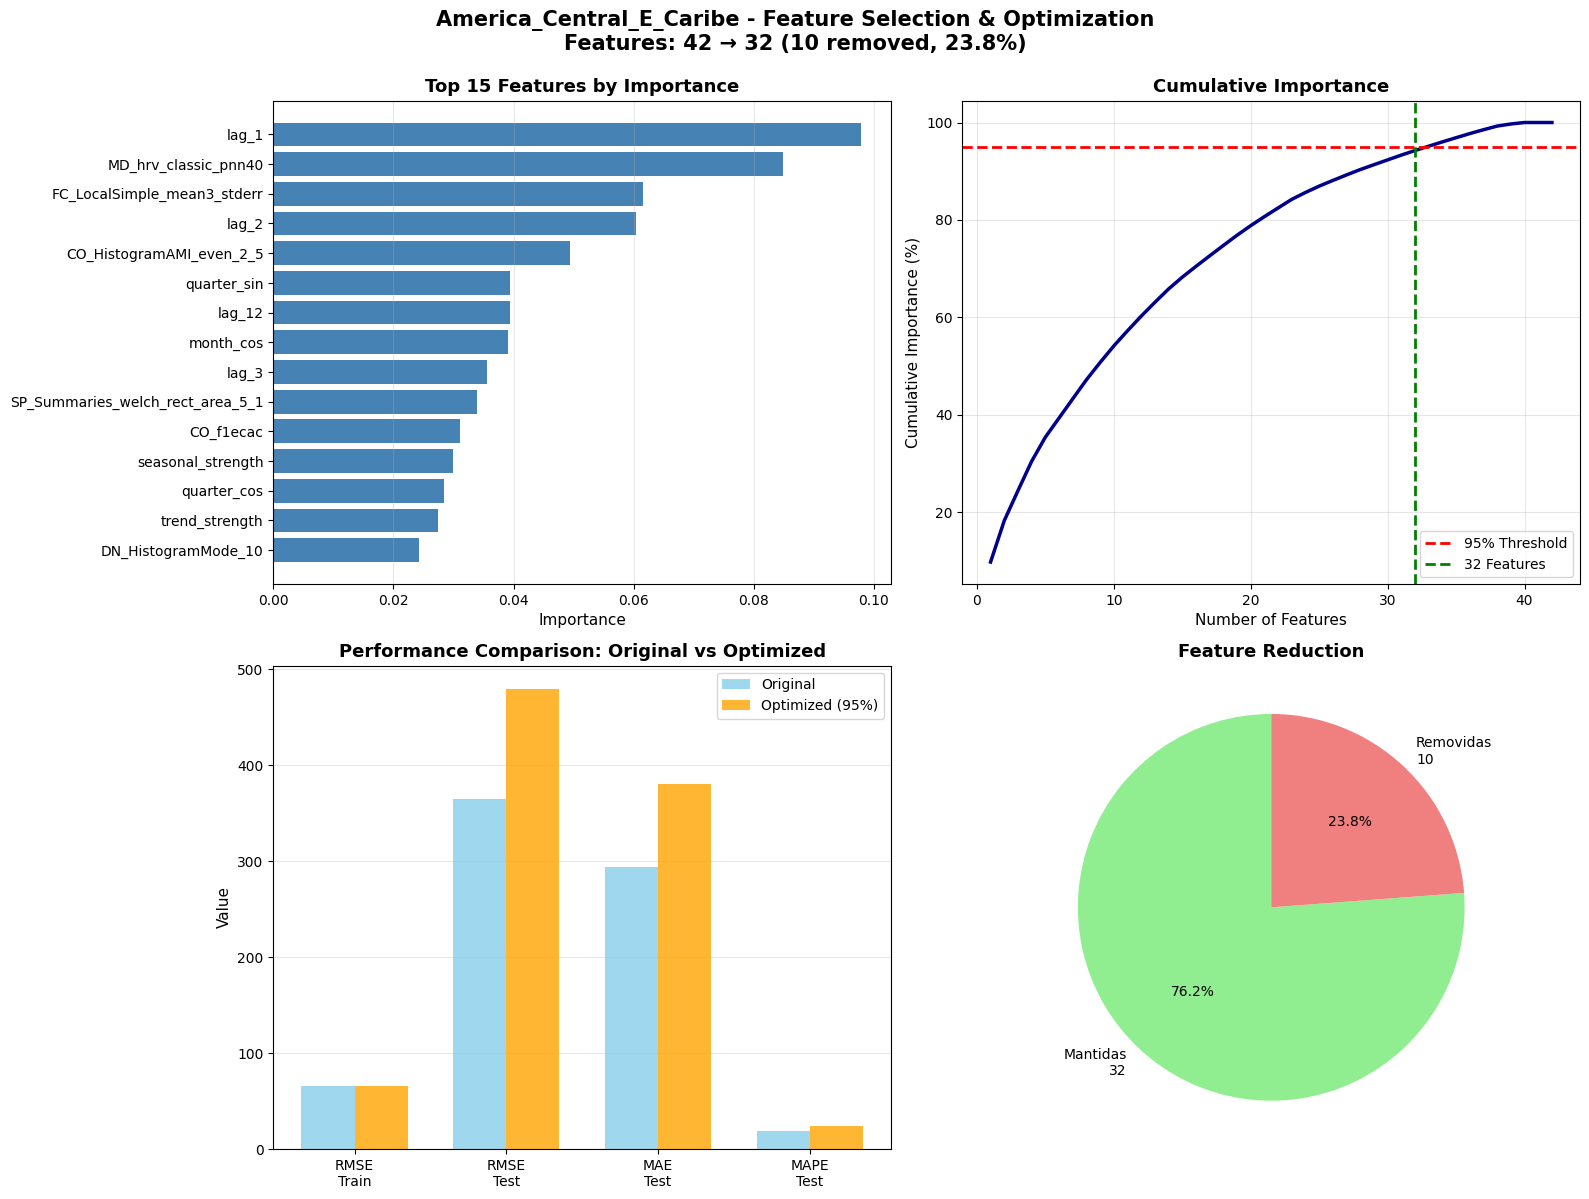


✓ Análise para America_Central_E_Caribe concluída!

SHAP ANALYSIS: AMERICA_DO_NORTE

Features originais: 42

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[1.4689371E4]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 32 (76.2%)
Features removidas: 10 (23.8%)

Features REMOVIDAS (10):
  1. trend_strength (Imp: 0.006913, Acum: 98.23%)
  2. seasonal_trough_year (Imp: 0.008278, Acum: 96.13%)
  3. linearity (Imp: 0.006069, Acum: 99.51%)
  4. curvature (Imp: 0.006797, Acum: 98.91%)
  5. stl_e_acf10 (Imp: 0.008527, Acum: 95.30%)
  6. DN_HistogramMode_10 (Imp: 0.006963, Acum: 97.54%)
  7. CO_FirstMin_ac (Imp: 0.007141, Acum: 96.84%)
  8. SB_BinaryStats_diff_longstretch0 (Imp: 0.004854, Acum: 100.00%)
  9. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  10. SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)

Top 10 Features MANTIDAS:
  1. lag_1 (Imp: 0.12

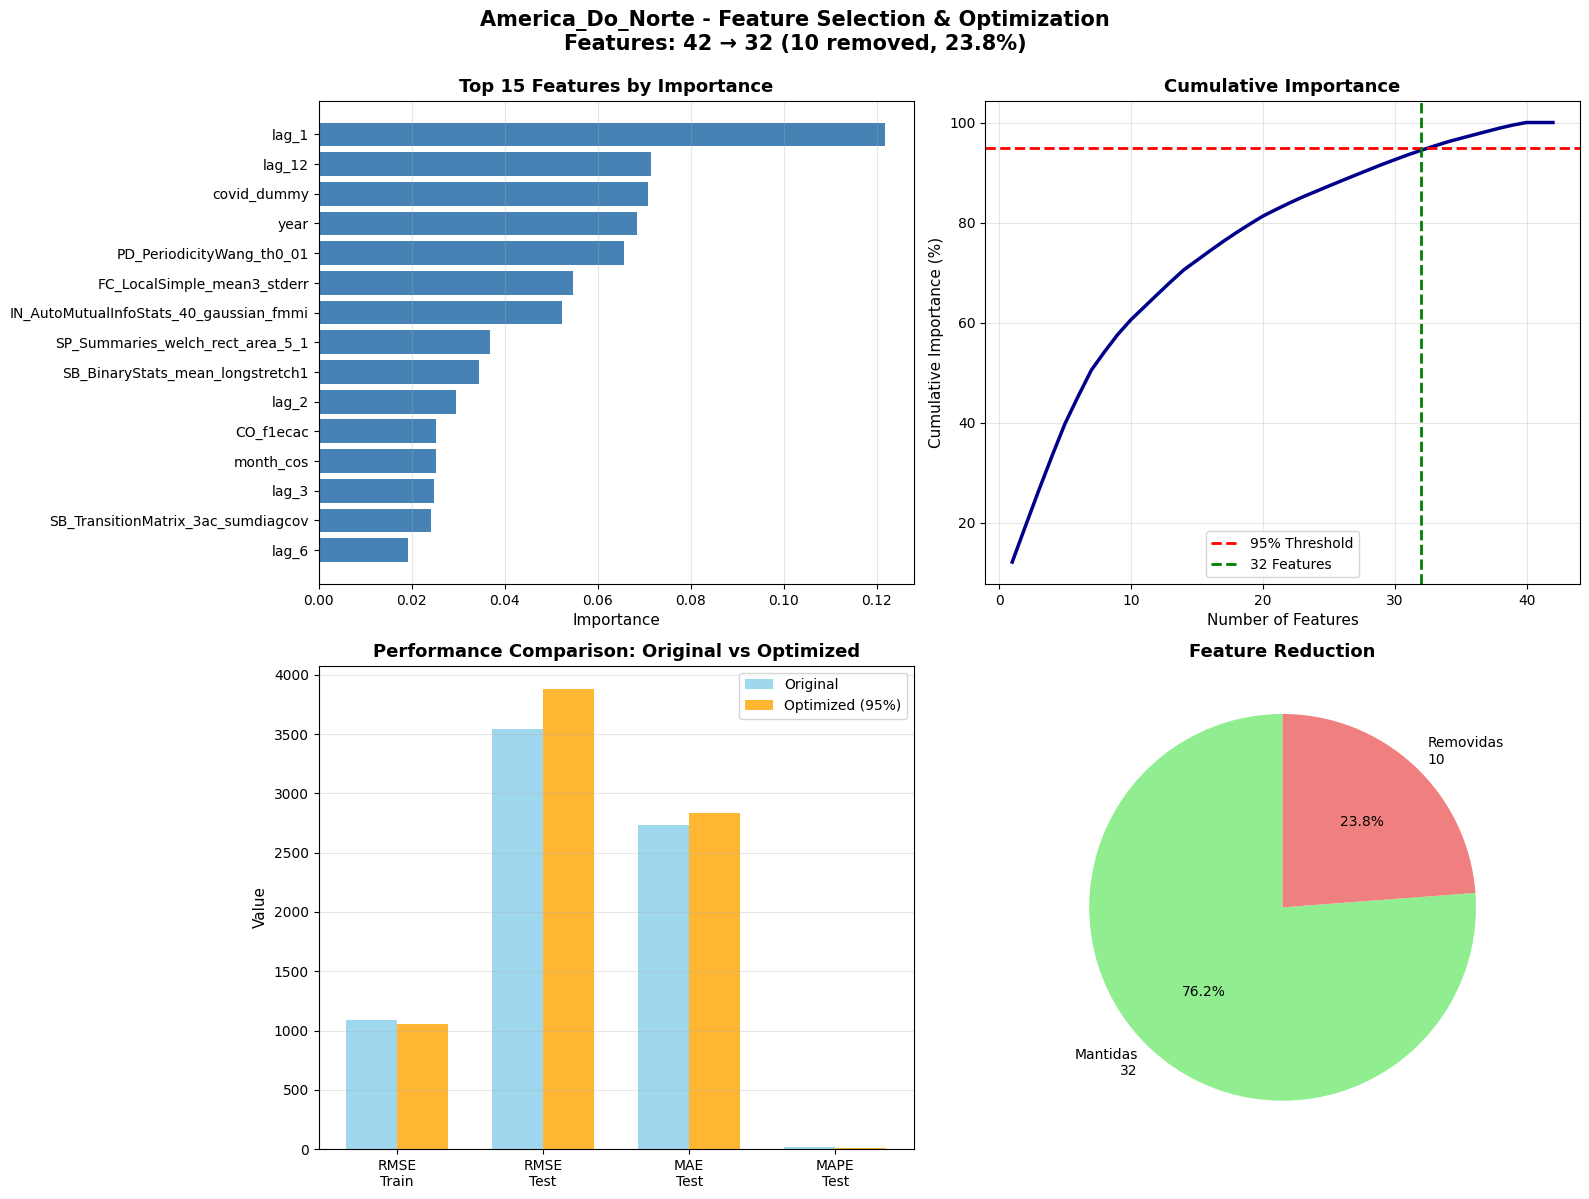


✓ Análise para America_Do_Norte concluída!

SHAP ANALYSIS: AMERICA_DO_SUL

Features originais: 42

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[3.0088895E4]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 28 (66.7%)
Features removidas: 14 (33.3%)

Features REMOVIDAS (14):
  1. spikiness (Imp: 0.006377, Acum: 97.24%)
  2. linearity (Imp: 0.000000, Acum: 100.00%)
  3. DN_HistogramMode_10 (Imp: 0.005910, Acum: 97.83%)
  4. CO_f1ecac (Imp: 0.007581, Acum: 95.21%)
  5. CO_FirstMin_ac (Imp: 0.003780, Acum: 99.67%)
  6. CO_HistogramAMI_even_2_5 (Imp: 0.005804, Acum: 98.41%)
  7. MD_hrv_classic_pnn40 (Imp: 0.004804, Acum: 98.89%)
  8. PD_PeriodicityWang_th0_01 (Imp: 0.000000, Acum: 100.00%)
  9. CO_Embed2_Dist_tau_d_expfit_meandiff (Imp: 0.007293, Acum: 95.94%)
  10. SB_BinaryStats_diff_longstretch0 (Imp: 0.003282, Acum: 100.00%)
  ... e mais 4 features

Top 10 Features MANTIDAS:
  1. lag_1 (Imp: 0.


✓ Análise para America_Do_Sul concluída!

SHAP ANALYSIS: ASIA

Features originais: 42

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[2.853572E3]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 31 (73.8%)
Features removidas: 11 (26.2%)

Features REMOVIDAS (11):
  1. quarter_sin (Imp: 0.006833, Acum: 99.33%)
  2. linearity (Imp: 0.000000, Acum: 100.00%)
  3. stl_e_acf1 (Imp: 0.002189, Acum: 100.00%)
  4. stl_e_acf10 (Imp: 0.010315, Acum: 95.86%)
  5. DN_HistogramMode_10 (Imp: 0.004531, Acum: 99.78%)
  6. SB_BinaryStats_mean_longstretch1 (Imp: 0.010287, Acum: 96.89%)
  7. PD_PeriodicityWang_th0_01 (Imp: 0.008628, Acum: 98.64%)
  8. IN_AutoMutualInfoStats_40_gaussian_fmmi (Imp: 0.000000, Acum: 100.00%)
  9. SB_BinaryStats_diff_longstretch0 (Imp: 0.008917, Acum: 97.78%)
  10. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  ... e mais 1 features

Top 10 Features MANTIDA

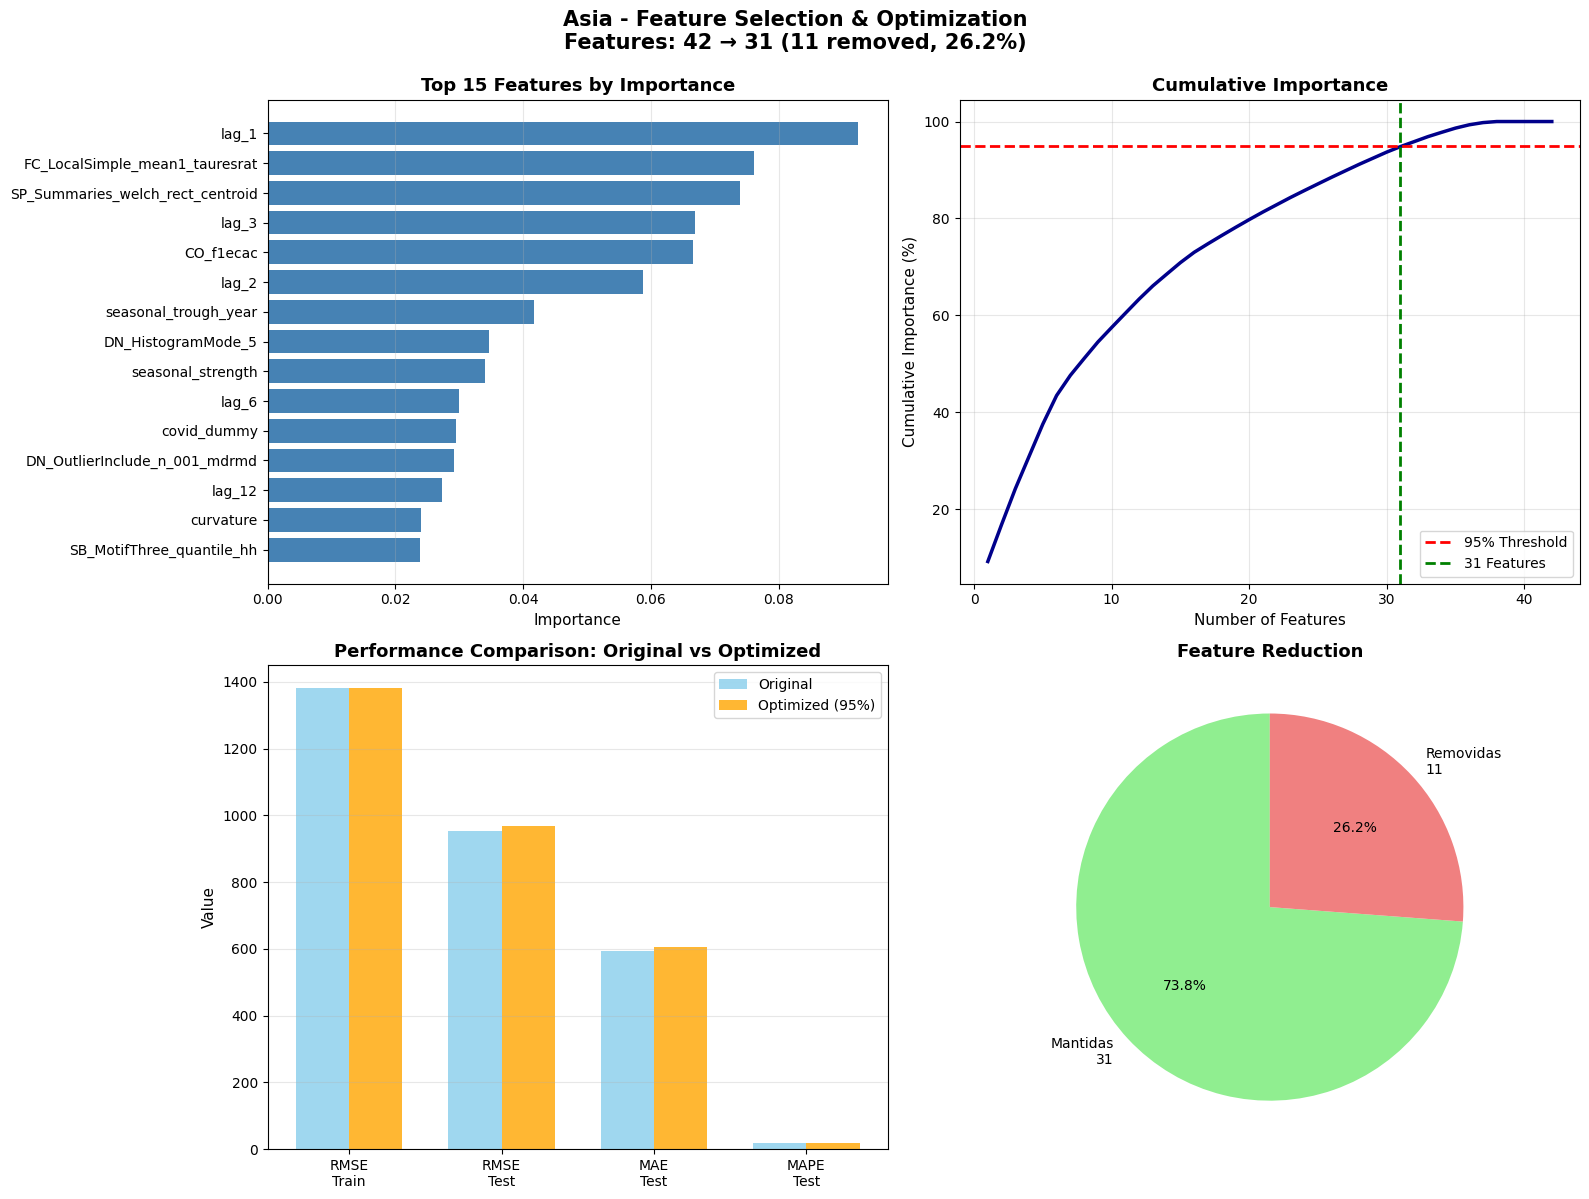


✓ Análise para Asia concluída!

SHAP ANALYSIS: EUROPA

Features originais: 42

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[3.0277246E4]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 31 (73.8%)
Features removidas: 11 (26.2%)

Features REMOVIDAS (11):
  1. quarter_sin (Imp: 0.006946, Acum: 97.84%)
  2. seasonal_strength (Imp: 0.005208, Acum: 99.67%)
  3. seasonal_peak_year (Imp: 0.007880, Acum: 96.40%)
  4. seasonal_trough_year (Imp: 0.006549, Acum: 99.15%)
  5. linearity (Imp: 0.000000, Acum: 100.00%)
  6. CO_FirstMin_ac (Imp: 0.007421, Acum: 97.14%)
  7. MD_hrv_classic_pnn40 (Imp: 0.008213, Acum: 95.61%)
  8. IN_AutoMutualInfoStats_40_gaussian_fmmi (Imp: 0.003285, Acum: 100.00%)
  9. SB_BinaryStats_diff_longstretch0 (Imp: 0.006607, Acum: 98.50%)
  10. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  ... e mais 1 features

Top 10 Features MANTIDAS:
  1. covid_du

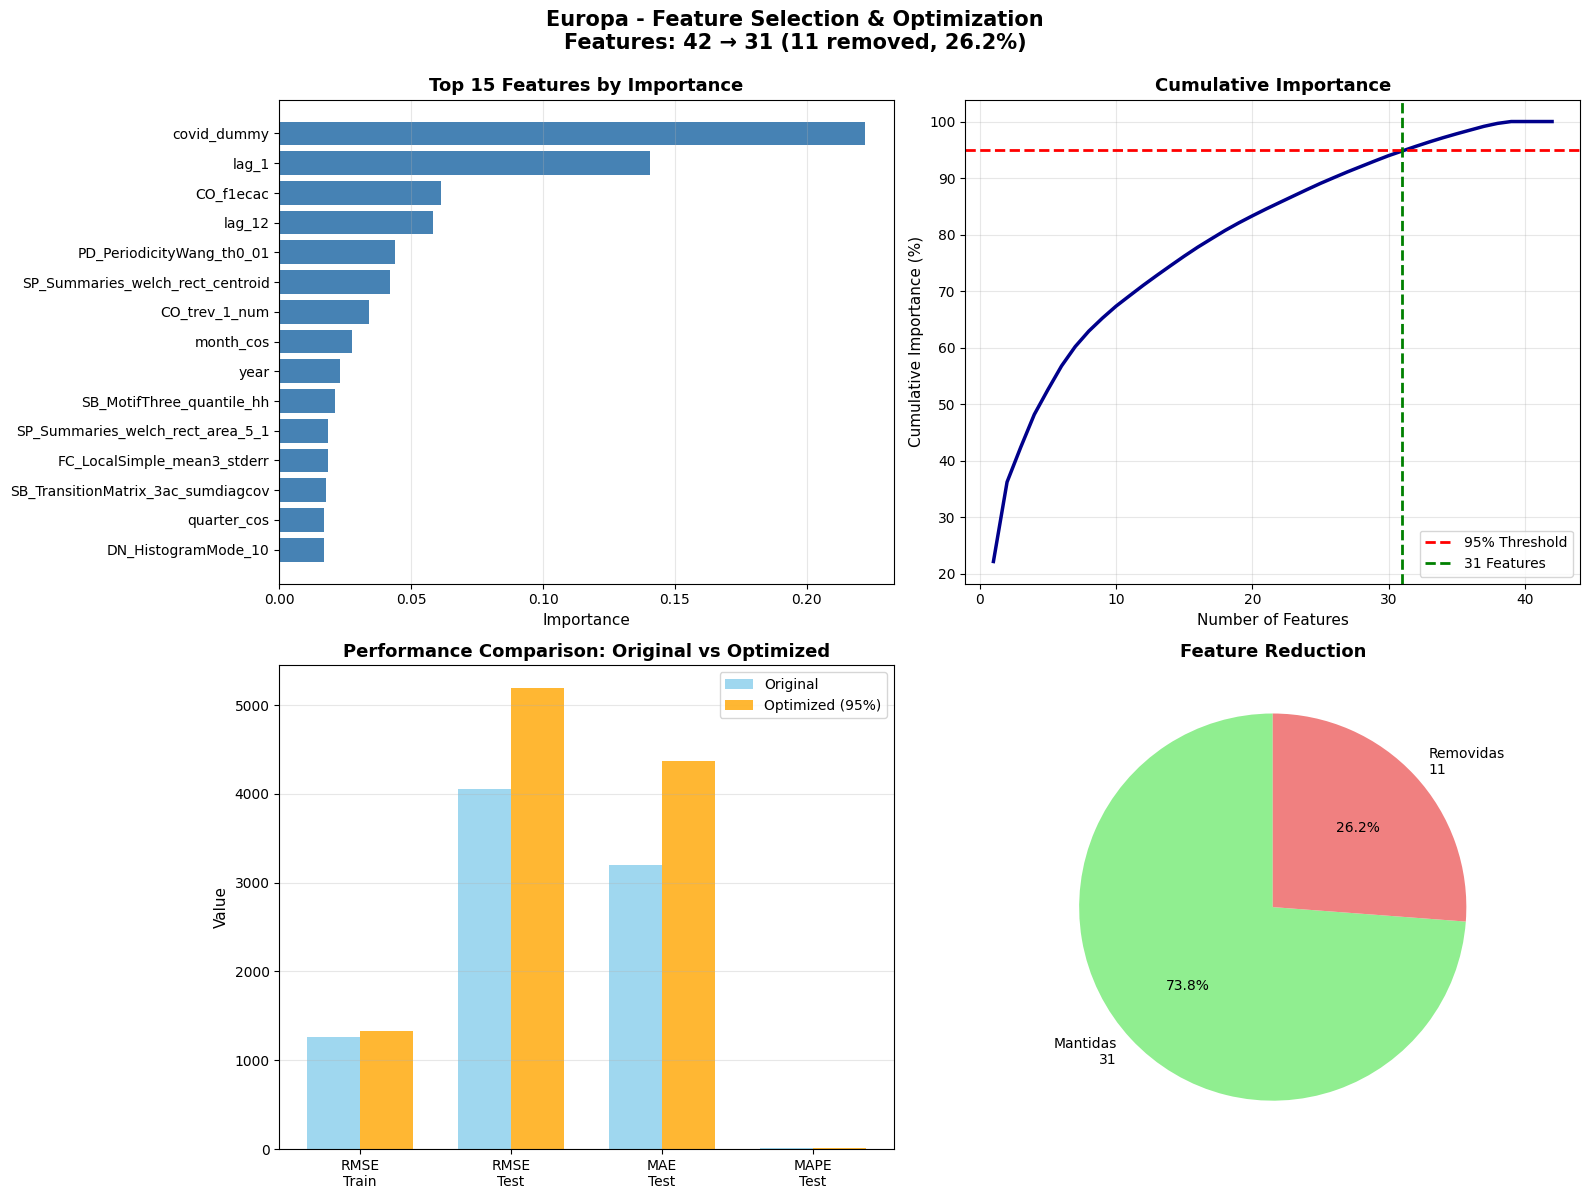


✓ Análise para Europa concluída!

SHAP ANALYSIS: OCEANIA

Features originais: 42

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[1.0687122E3]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 33 (78.6%)
Features removidas: 9 (21.4%)

Features REMOVIDAS (9):
  1. seasonal_trough_year (Imp: 0.005959, Acum: 100.00%)
  2. CO_trev_1_num (Imp: 0.008726, Acum: 97.18%)
  3. PD_PeriodicityWang_th0_01 (Imp: 0.010738, Acum: 95.25%)
  4. DN_OutlierInclude_n_001_mdrmd (Imp: 0.008283, Acum: 98.01%)
  5. SB_BinaryStats_diff_longstretch0 (Imp: 0.006430, Acum: 99.40%)
  6. SB_MotifThree_quantile_hh (Imp: 0.010550, Acum: 96.31%)
  7. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  8. SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  9. FC_LocalSimple_mean3_stderr (Imp: 0.007524, Acum: 98.76%)

Top 10 Features MANTIDAS:
  1. MD_hrv_classic_pnn40 (Imp: 0.077667, Ac

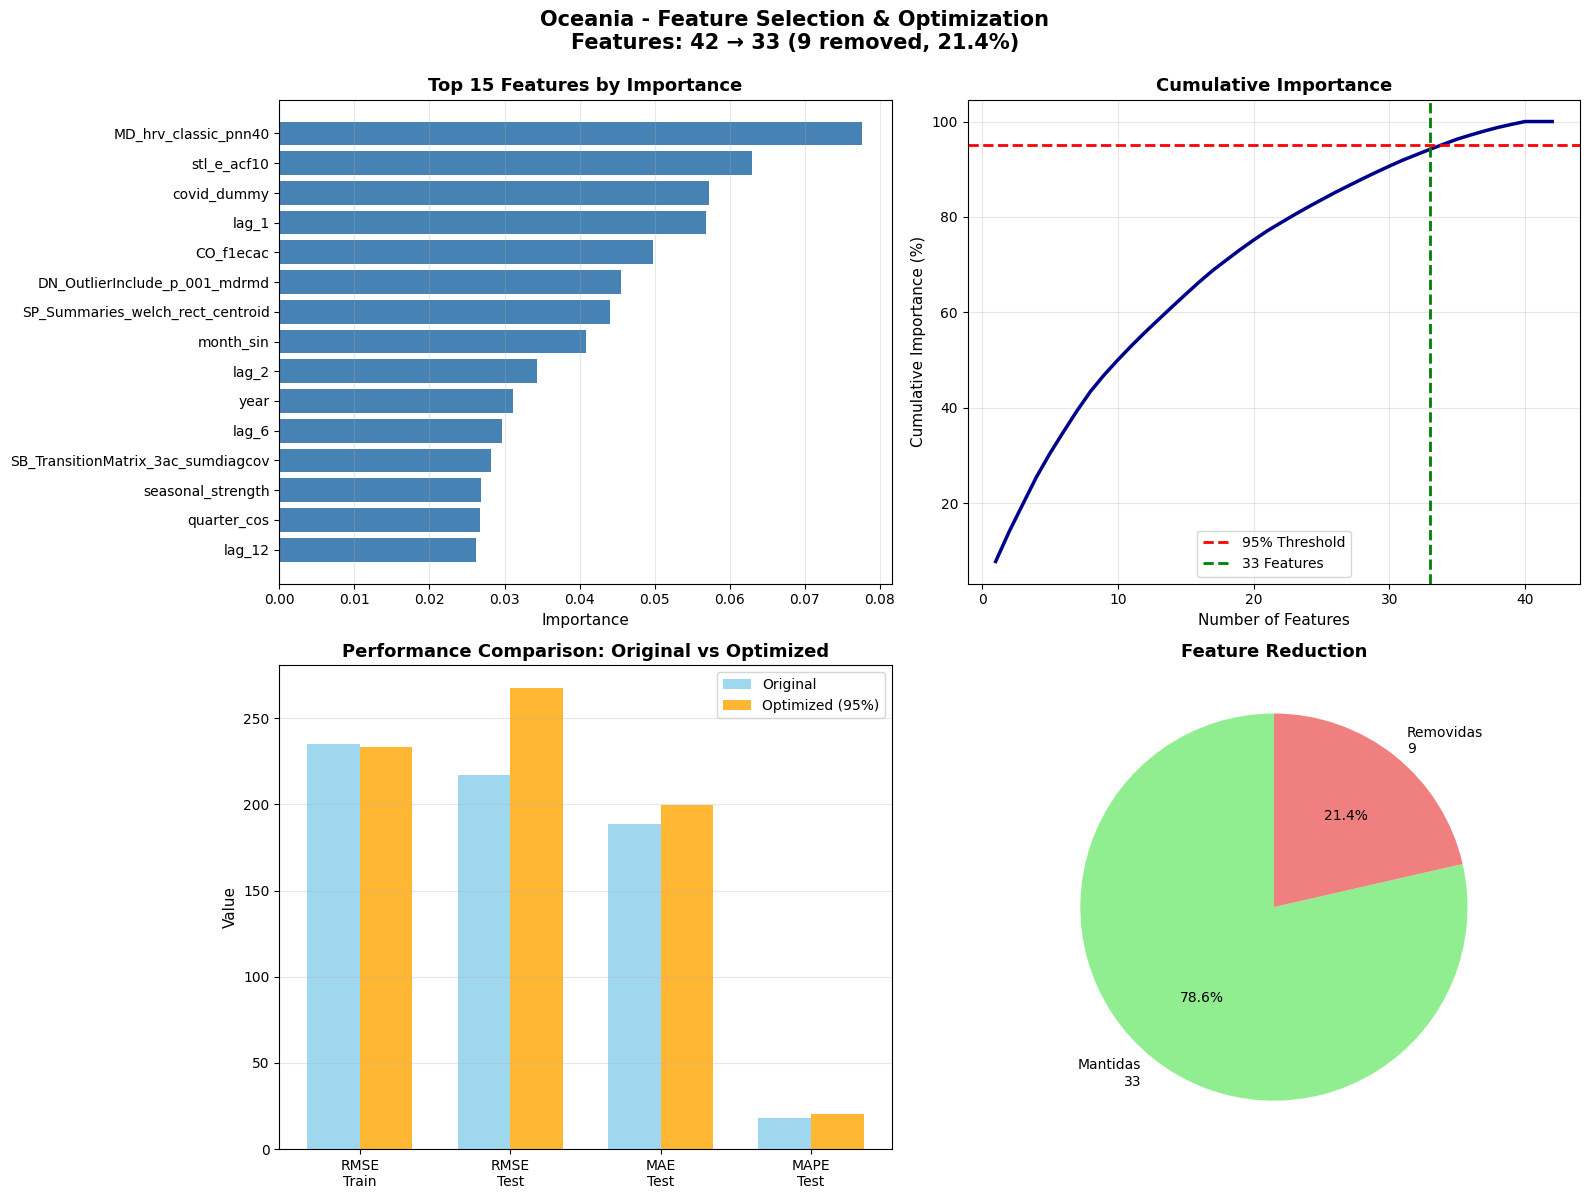


✓ Análise para Oceania concluída!

SHAP ANALYSIS: TOTAL

Features originais: 42

Calculando SHAP values...
⚠️ ERRO ao calcular SHAP: could not convert string to float: '[8.111224E4]'
Tentando método alternativo...

--- Feature Selection (95% Importance) ---
Features selecionadas: 30 (71.4%)
Features removidas: 12 (28.6%)

Features REMOVIDAS (12):
  1. month_sin (Imp: 0.008472, Acum: 95.58%)
  2. trend_strength (Imp: 0.007287, Acum: 97.93%)
  3. linearity (Imp: 0.000000, Acum: 100.00%)
  4. curvature (Imp: 0.007953, Acum: 97.20%)
  5. CO_FirstMin_ac (Imp: 0.000883, Acum: 100.00%)
  6. MD_hrv_classic_pnn40 (Imp: 0.004347, Acum: 99.49%)
  7. SB_TransitionMatrix_3ac_sumdiagcov (Imp: 0.008212, Acum: 96.40%)
  8. CO_Embed2_Dist_tau_d_expfit_meandiff (Imp: 0.006556, Acum: 98.58%)
  9. IN_AutoMutualInfoStats_40_gaussian_fmmi (Imp: 0.004690, Acum: 99.05%)
  10. SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 (Imp: 0.000000, Acum: 100.00%)
  ... e mais 2 features

Top 10 Features MANTIDAS:
  1. lag


✓ Análise para TOTAL concluída!

RESUMO CONSOLIDADO - FEATURE SELECTION

--- Redução de Features ---
               Continent  Features_Original  Features_Selected  Features_Removed  Reduction_Pct
                  Africa                 42                 34                 8      19.047619
America_Central_E_Caribe                 42                 32                10      23.809524
        America_Do_Norte                 42                 32                10      23.809524
          America_Do_Sul                 42                 28                14      33.333333
                    Asia                 42                 31                11      26.190476
                  Europa                 42                 31                11      26.190476
                 Oceania                 42                 33                 9      21.428571
                   TOTAL                 42                 30                12      28.571429

--- Impacto no Test RMSE ---
    

In [12]:
import shap
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("ANÁLISE SHAP E SELEÇÃO DE FEATURES - TOP 95%")
print("="*80 + "\n")

# ========================================
# ANÁLISE SHAP POR CONTINENTE
# ========================================
shap_results = []
optimized_models = {}

for continent in continents:
    if continent not in xgb_models:
        continue
    
    print(f"\n{'='*80}")
    print(f"SHAP ANALYSIS: {continent.upper()}")
    print(f"{'='*80}\n")
    
    # Carregar modelo e dados
    model_data = xgb_models[continent]
    best_model = model_data['model']
    train_data = model_data['train_data']
    test_data = model_data['test_data']
    feature_cols = model_data['feature_cols']
    
    X_train = train_data[feature_cols]
    y_train = train_data['arrivals']
    X_test = test_data[feature_cols]
    y_test = test_data['arrivals']
    
    print(f"Features originais: {len(feature_cols)}")
    
    # ========================================
    # CALCULAR SHAP VALUES
    # ========================================
    print("\nCalculando SHAP values...")
    
    # ✅ FIX: Usar TreeExplainer com model_output='raw'
    try:
        explainer = shap.TreeExplainer(best_model, X_train, model_output='raw')
        shap_values = explainer.shap_values(X_train)
    except Exception as e:
        print(f"⚠️ ERRO ao calcular SHAP: {e}")
        print("Tentando método alternativo...")
        
        # Fallback: usar feature_importances_ do XGBoost
        shap_importance = best_model.feature_importances_
        
        shap_df = pd.DataFrame({
            'feature': feature_cols,
            'shap_importance': shap_importance
        }).sort_values('shap_importance', ascending=False).reset_index(drop=True)
        
        shap_df['cumulative_importance'] = shap_df['shap_importance'].cumsum() / shap_df['shap_importance'].sum() * 100
        
        shap_values = None  # Flag para pular visualização SHAP
        
    # Se SHAP funcionou, calcular importância
    if shap_values is not None:
        # Feature importance baseada em SHAP (média absoluta)
        shap_importance = np.abs(shap_values).mean(axis=0)
        
        # Criar DataFrame de importância
        shap_df = pd.DataFrame({
            'feature': feature_cols,
            'shap_importance': shap_importance
        }).sort_values('shap_importance', ascending=False).reset_index(drop=True)
        
        # Calcular importância acumulada
        shap_df['cumulative_importance'] = shap_df['shap_importance'].cumsum() / shap_df['shap_importance'].sum() * 100
    
    # ========================================
    # SELECIONAR FEATURES TOP 95%
    # ========================================
    features_95 = shap_df[shap_df['cumulative_importance'] <= 95].copy()
    selected_features = features_95['feature'].tolist()
    
    removed_features = [f for f in feature_cols if f not in selected_features]
    
    print(f"\n--- Feature Selection (95% Importance) ---")
    print(f"Features selecionadas: {len(selected_features)} ({len(selected_features)/len(feature_cols)*100:.1f}%)")
    print(f"Features removidas: {len(removed_features)} ({len(removed_features)/len(feature_cols)*100:.1f}%)")
    
    if len(removed_features) > 0:
        print(f"\nFeatures REMOVIDAS ({len(removed_features)}):")
        for i, feat in enumerate(removed_features[:10], 1):  # Mostrar apenas top 10
            feat_data = shap_df[shap_df['feature'] == feat].iloc[0]
            print(f"  {i}. {feat} (Imp: {feat_data['shap_importance']:.6f}, Acum: {feat_data['cumulative_importance']:.2f}%)")
        
        if len(removed_features) > 10:
            print(f"  ... e mais {len(removed_features) - 10} features")
    
    print(f"\nTop 10 Features MANTIDAS:")
    for i, (_, row) in enumerate(features_95.head(10).iterrows(), 1):
        print(f"  {i}. {row['feature']} (Imp: {row['shap_importance']:.6f}, Acum: {row['cumulative_importance']:.2f}%)")
    
    # ========================================
    # RETREINAR MODELO COM FEATURES SELECIONADAS
    # ========================================
    print(f"\nRetreinando modelo com {len(selected_features)} features...")
    
    # Pegar melhores parâmetros do grid search
    result = results_df[results_df['Continent'] == continent].iloc[0]
    
    best_params = {
        'n_estimators': int(result['n_estimators']),
        'learning_rate': result['learning_rate'],
        'max_depth': int(result['max_depth']),
        'min_child_weight': int(result['min_child_weight']),
        'subsample': result['subsample'],
        'colsample_bytree': result['colsample_bytree'],
        'random_state': 42,
        'verbosity': 0
    }
    
    # Treinar modelo otimizado
    X_train_opt = X_train[selected_features]
    X_test_opt = X_test[selected_features]
    
    import xgboost as xgb
    model_optimized = xgb.XGBRegressor(**best_params)
    model_optimized.fit(X_train_opt, y_train)
    
    # Predições
    y_pred_train_opt = model_optimized.predict(X_train_opt)
    y_pred_test_opt = model_optimized.predict(X_test_opt)
    
    # ========================================
    # COMPARAÇÃO DE RESULTADOS
    # ========================================
    # Modelo ORIGINAL (todas features)
    y_pred_train_orig = best_model.predict(X_train)
    y_pred_test_orig = best_model.predict(X_test)
    
    # Métricas ORIGINAL
    rmse_train_orig = np.sqrt(mean_squared_error(y_train, y_pred_train_orig))
    rmse_test_orig = np.sqrt(mean_squared_error(y_test, y_pred_test_orig))
    mae_train_orig = mean_absolute_error(y_train, y_pred_train_orig)
    mae_test_orig = mean_absolute_error(y_test, y_pred_test_orig)
    
    mask_train = y_train > 0
    mask_test = y_test > 0
    mape_train_orig = np.mean(np.abs((y_train[mask_train] - y_pred_train_orig[mask_train]) / y_train[mask_train])) * 100 if mask_train.sum() > 0 else np.nan
    mape_test_orig = np.mean(np.abs((y_test[mask_test] - y_pred_test_orig[mask_test]) / y_test[mask_test])) * 100 if mask_test.sum() > 0 else np.nan
    
    # Métricas OTIMIZADO
    rmse_train_opt = np.sqrt(mean_squared_error(y_train, y_pred_train_opt))
    rmse_test_opt = np.sqrt(mean_squared_error(y_test, y_pred_test_opt))
    mae_train_opt = mean_absolute_error(y_train, y_pred_train_opt)
    mae_test_opt = mean_absolute_error(y_test, y_pred_test_opt)
    
    mape_train_opt = np.mean(np.abs((y_train[mask_train] - y_pred_train_opt[mask_train]) / y_train[mask_train])) * 100 if mask_train.sum() > 0 else np.nan
    mape_test_opt = np.mean(np.abs((y_test[mask_test] - y_pred_test_opt[mask_test]) / y_test[mask_test])) * 100 if mask_test.sum() > 0 else np.nan
    
    # Diferenças
    delta_rmse_train = rmse_train_opt - rmse_train_orig
    delta_rmse_test = rmse_test_opt - rmse_test_orig
    delta_mae_train = mae_train_opt - mae_train_orig
    delta_mae_test = mae_test_opt - mae_test_orig
    delta_mape_train = mape_train_opt - mape_train_orig
    delta_mape_test = mape_test_opt - mape_test_orig
    
    print(f"\n{'='*60}")
    print(f"COMPARAÇÃO: ORIGINAL vs OTIMIZADO (95%)")
    print(f"{'='*60}")
    
    print(f"\n{'Métrica':<15} {'Original':<12} {'Otimizado':<12} {'Delta':<12} {'%':<10}")
    print("-" * 60)
    
    # TRAIN
    print(f"TRAIN RMSE:     {rmse_train_orig:<12.2f} {rmse_train_opt:<12.2f} {delta_rmse_train:<12.2f} {delta_rmse_train/rmse_train_orig*100:>8.2f}%")
    print(f"TRAIN MAE:      {mae_train_orig:<12.2f} {mae_train_opt:<12.2f} {delta_mae_train:<12.2f} {delta_mae_train/mae_train_orig*100:>8.2f}%")
    print(f"TRAIN MAPE:     {mape_train_orig:<12.2f} {mape_train_opt:<12.2f} {delta_mape_train:<12.2f} {delta_mape_train/mape_train_orig*100:>8.2f}%")
    
    print("-" * 60)
    
    # TEST
    print(f"TEST RMSE:      {rmse_test_orig:<12.2f} {rmse_test_opt:<12.2f} {delta_rmse_test:<12.2f} {delta_rmse_test/rmse_test_orig*100:>8.2f}%")
    print(f"TEST MAE:       {mae_test_orig:<12.2f} {mae_test_opt:<12.2f} {delta_mae_test:<12.2f} {delta_mae_test/mae_test_orig*100:>8.2f}%")
    print(f"TEST MAPE:      {mape_test_orig:<12.2f} {mape_test_opt:<12.2f} {delta_mape_test:<12.2f} {delta_mape_test/mape_test_orig*100:>8.2f}%")
    
    print("-" * 60)
    
    # GAP
    gap_orig = abs(rmse_train_orig - rmse_test_orig)
    gap_opt = abs(rmse_train_opt - rmse_test_opt)
    delta_gap = gap_opt - gap_orig
    
    print(f"GAP (|Tr-Te|):  {gap_orig:<12.2f} {gap_opt:<12.2f} {delta_gap:<12.2f} {delta_gap/gap_orig*100:>8.2f}%")
    
    # Interpretação
    print(f"\n--- Interpretação ---")
    
    if delta_rmse_test < 0:
        print(f"✓ MELHORIA: Test RMSE reduziu {abs(delta_rmse_test):.2f} ({abs(delta_rmse_test/rmse_test_orig*100):.2f}%)")
    elif delta_rmse_test > 0:
        print(f"⚠️ PIORA: Test RMSE aumentou {delta_rmse_test:.2f} ({delta_rmse_test/rmse_test_orig*100:.2f}%)")
    else:
        print(f"= NEUTRO: Test RMSE manteve-se igual")
    
    if abs(delta_rmse_test / rmse_test_orig * 100) < 1:
        print(f"  → Mudança INSIGNIFICANTE (< 1%)")
        impact = "Insignificant"
    elif abs(delta_rmse_test / rmse_test_orig * 100) < 5:
        print(f"  → Mudança MODERADA (1-5%)")
        impact = "Moderate"
    else:
        print(f"  → Mudança SIGNIFICATIVA (> 5%)")
        impact = "Significant"
    
    # ========================================
    # ARMAZENAR RESULTADOS
    # ========================================
    shap_results.append({
        'Continent': continent,
        'Features_Original': len(feature_cols),
        'Features_Selected': len(selected_features),
        'Features_Removed': len(removed_features),
        'Reduction_Pct': len(removed_features) / len(feature_cols) * 100,
        'RMSE_Train_Orig': rmse_train_orig,
        'RMSE_Train_Opt': rmse_train_opt,
        'RMSE_Test_Orig': rmse_test_orig,
        'RMSE_Test_Opt': rmse_test_opt,
        'Delta_RMSE_Train': delta_rmse_train,
        'Delta_RMSE_Test': delta_rmse_test,
        'Delta_RMSE_Test_Pct': delta_rmse_test / rmse_test_orig * 100,
        'MAE_Test_Orig': mae_test_orig,
        'MAE_Test_Opt': mae_test_opt,
        'MAPE_Test_Orig': mape_test_orig,
        'MAPE_Test_Opt': mape_test_opt,
        'GAP_Orig': gap_orig,
        'GAP_Opt': gap_opt,
        'Impact': impact
    })
    
    optimized_models[continent] = {
        'model': model_optimized,
        'selected_features': selected_features,
        'removed_features': removed_features,
        'shap_df': shap_df,
        'train_data': train_data,
        'test_data': test_data,
        'y_pred_train': y_pred_train_opt,
        'y_pred_test': y_pred_test_opt
    }
    
    # ========================================
    # VISUALIZAÇÃO (SEM SHAP PLOTS)
    # ========================================
    print(f"\nGerando visualizações...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Feature Importance (bar)
    axes[0, 0].barh(range(min(15, len(shap_df))), 
                    shap_df['shap_importance'].head(15)[::-1], 
                    color='steelblue')
    axes[0, 0].set_yticks(range(min(15, len(shap_df))))
    axes[0, 0].set_yticklabels(shap_df['feature'].head(15)[::-1])
    axes[0, 0].set_xlabel('Importance', fontsize=11)
    axes[0, 0].set_title('Top 15 Features by Importance', 
                         fontsize=13, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Cumulative Importance
    axes[0, 1].plot(range(1, len(shap_df) + 1), 
                    shap_df['cumulative_importance'], 
                    linewidth=2.5, color='darkblue')
    axes[0, 1].axhline(y=95, color='red', linestyle='--', 
                       linewidth=2, label='95% Threshold')
    axes[0, 1].axvline(x=len(selected_features), color='green', 
                       linestyle='--', linewidth=2, 
                       label=f'{len(selected_features)} Features')
    axes[0, 1].set_xlabel('Number of Features', fontsize=11)
    axes[0, 1].set_ylabel('Cumulative Importance (%)', fontsize=11)
    axes[0, 1].set_title('Cumulative Importance', 
                         fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Performance Comparison
    metrics = ['RMSE\nTrain', 'RMSE\nTest', 'MAE\nTest', 'MAPE\nTest']
    orig_values = [rmse_train_orig, rmse_test_orig, mae_test_orig, mape_test_orig]
    opt_values = [rmse_train_opt, rmse_test_opt, mae_test_opt, mape_test_opt]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, orig_values, width, label='Original', 
                   color='skyblue', alpha=0.8)
    axes[1, 0].bar(x + width/2, opt_values, width, label='Optimized (95%)', 
                   color='orange', alpha=0.8)
    
    axes[1, 0].set_ylabel('Value', fontsize=11)
    axes[1, 0].set_title('Performance Comparison: Original vs Optimized', 
                         fontsize=13, fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(metrics)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Feature Reduction Pie Chart
    axes[1, 1].pie([len(selected_features), len(removed_features)],
                   labels=[f'Mantidas\n{len(selected_features)}', 
                          f'Removidas\n{len(removed_features)}'],
                   autopct='%1.1f%%',
                   colors=['lightgreen', 'lightcoral'],
                   startangle=90)
    axes[1, 1].set_title('Feature Reduction', 
                         fontsize=13, fontweight='bold')
    
    plt.suptitle(f'{continent.title()} - Feature Selection & Optimization\n' +
                 f'Features: {len(feature_cols)} → {len(selected_features)} ' +
                 f'({len(removed_features)} removed, {len(removed_features)/len(feature_cols)*100:.1f}%)',
                 fontsize=15, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Análise para {continent} concluída!")


# ========================================
# RESUMO CONSOLIDADO
# ========================================
print("\n" + "="*80)
print("RESUMO CONSOLIDADO - FEATURE SELECTION")
print("="*80 + "\n")

shap_summary_df = pd.DataFrame(shap_results)

print("--- Redução de Features ---")
print(shap_summary_df[['Continent', 'Features_Original', 'Features_Selected', 
                       'Features_Removed', 'Reduction_Pct']].to_string(index=False))

print("\n--- Impacto no Test RMSE ---")
print(shap_summary_df[['Continent', 'RMSE_Test_Orig', 'RMSE_Test_Opt', 
                       'Delta_RMSE_Test', 'Delta_RMSE_Test_Pct', 'Impact']].to_string(index=False))

print("\n--- Estatísticas Gerais ---")
print(f"Redução média de features: {shap_summary_df['Reduction_Pct'].mean():.2f}%")
print(f"Variação média Test RMSE: {shap_summary_df['Delta_RMSE_Test_Pct'].mean():.2f}%")

improved = (shap_summary_df['Delta_RMSE_Test'] < 0).sum()
worsened = (shap_summary_df['Delta_RMSE_Test'] > 0).sum()
neutral = (shap_summary_df['Delta_RMSE_Test'] == 0).sum()

print(f"\nContinentes com MELHORIA: {improved} ({improved/len(shap_summary_df)*100:.1f}%)")
print(f"Continentes com PIORA: {worsened} ({worsened/len(shap_summary_df)*100:.1f}%)")
print(f"Continentes NEUTROS: {neutral} ({neutral/len(shap_summary_df)*100:.1f}%)")

print("\n" + "="*80)
print("✓ ANÁLISE CONCLUÍDA")
print("="*80)

In [13]:
# ✅ CONSOLIDAR PREVISÕES DE TODOS OS CONTINENTES
all_forecasts = []

for continent in continents:
    if continent not in xgb_models:
        continue
    
    model_data = xgb_models[continent]
    test_data = model_data['test_data']
    y_pred_test = model_data['y_pred_test']
    
    continent_display = "TOTAL (Agregado)" if continent == 'TOTAL' else continent.title()
    
    # ✅ FIX: Calcular pct_error com numpy, depois substituir inf/nan
    actual = test_data['arrivals'].values
    forecast = y_pred_test
    pct_error = ((actual - forecast) / actual) * 100
    pct_error = np.where(np.isinf(pct_error) | np.isnan(pct_error), np.nan, pct_error)
    
    forecast_df = pd.DataFrame({
        'date': test_data['date'].values,
        'continent': continent_display,
        'actual': actual,
        'forecast': forecast,
        'error': actual - forecast,
        'abs_error': np.abs(actual - forecast),
        'pct_error': pct_error
    })
    
    all_forecasts.append(forecast_df)
    
    train_data = model_data['train_data']
    y_pred_train = model_data['y_pred_train']
    
    actual_train = train_data['arrivals'].values
    forecast_train = y_pred_train
    pct_error_train = ((actual_train - forecast_train) / actual_train) * 100
    pct_error_train = np.where(np.isinf(pct_error_train) | np.isnan(pct_error_train), np.nan, pct_error_train)
    
    train_forecast_df = pd.DataFrame({
        'date': train_data['date'].values,
        'continent': continent_display,
        'actual': actual_train,
        'forecast': forecast_train,
        'error': actual_train - forecast_train,
        'abs_error': np.abs(actual_train - forecast_train),
        'pct_error': pct_error_train
    })
    
    if 'all_train_forecasts' not in locals():
        all_train_forecasts = []
    
    all_train_forecasts.append(train_forecast_df)

# Consolidar
forecasts_final = pd.concat(all_forecasts, ignore_index=True)

print("="*80)
print("PREVISÕES CONSOLIDADAS - XGBOOST")
print("="*80)
print(f"Total de previsões: {len(forecasts_final)}")
print(f"Continentes: {forecasts_final['continent'].nunique()}")
print(f"Período: {forecasts_final['date'].min().strftime('%Y-%m')} a {forecasts_final['date'].max().strftime('%Y-%m')}")

display(forecasts_final.head(20))

# Salvar
output_path = PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_forecasts_catch_exog.csv"
forecasts_final.to_csv(output_path, index=False)
print(f"\n✓ Salvo em: {output_path}")

if 'all_train_forecasts' in locals() and len(all_train_forecasts) > 0:
    train_forecasts_final = pd.concat(all_train_forecasts, ignore_index=True)
    
    print("\n" + "="*80)
    print("PREVISÕES CONSOLIDADAS - XGBOOST (TREINO)")
    print("="*80)
    print(f"Total de fitted values: {len(train_forecasts_final)}")
    print(f"Continentes: {train_forecasts_final['continent'].nunique()}")
    print(f"Período: {train_forecasts_final['date'].min().strftime('%Y-%m')} a {train_forecasts_final['date'].max().strftime('%Y-%m')}")
    
    display(train_forecasts_final.head(20))
    
    output_path_train = PROJECT_ROOT / "notebooks" / "modeling" / "xgboost_forecasts_TRAIN_catch_exog.csv"
    train_forecasts_final.to_csv(output_path_train, index=False)
    print(f"\n✓ Salvo em: {output_path_train}")

PREVISÕES CONSOLIDADAS - XGBOOST
Total de previsões: 96
Continentes: 8
Período: 2024-01 a 2024-12


date                 continent  actual     forecast       error  \
0  2024-01-01                    Africa   303.0   342.019073  -39.019073   
1  2024-02-01                    Africa   446.0   387.959229   58.040771   
2  2024-03-01                    Africa   337.0   366.583771  -29.583771   
3  2024-04-01                    Africa   402.0   371.283020   30.716980   
4  2024-05-01                    Africa   397.0   312.773987   84.226013   
5  2024-06-01                    Africa   225.0   331.762177 -106.762177   
6  2024-07-01                    Africa   259.0   363.421143 -104.421143   
7  2024-08-01                    Africa   260.0   340.659851  -80.659851   
8  2024-09-01                    Africa   302.0   328.342896  -26.342896   
9  2024-10-01                    Africa   342.0   359.130768  -17.130768   
10 2024-11-01                    Africa   546.0   329.683258  216.316742   
11 2024-12-01                    Africa   439.0   449.509979  -10.509979   
12 2024-01-01  America_Central_E_Caribe   912.0  1056.995972 -144.995972   
13 2024-02-01  America_Central_E_Caribe   843.0   883.118469  -40.118469   
14 2024-03-01  America_Central_E_Caribe  1302.0   899.758118  402.241882   
15 2024-04-01  America_Central_E_Caribe  1082.0   977.355347  104.644653   
16 2024-05-01  America_Central_E_Caribe  1155.0  1084.108765   70.891235   
17 2024-06-01  America_Central_E_Caribe  1293.0  1062.865356  230.134644   
18 2024-07-01  America_Central_E_Caribe  1038.0  1198.455933 -160.455933   
19 2024-08-01  America_Central_E_Caribe  1337.0  1105.853516  231.146484   

     abs_error  pct_error  
0    39.019073 -12.877582  
1    58.040771  13.013626  
2    29.583771  -8.778567  
3    30.716980   7.641040  
4    84.226013  21.215620  
5   106.762177 -47.449856  
6   104.421143 -40.317043  
7    80.659851 -31.023020  
8    26.342896  -8.722813  
9    17.130768  -5.008996  
10  216.316742  39.618451  
11   10.509979  -2.394073  
12  144.995972 -15.898681  
13   40.118469  -4.759012  
14  402.241882  30.894154  
15  104.644653   9.671410  
16   70.891235   6.137769  
17  230.134644  17.798503  
18  160.455933 -15.458182  
19  231.146484  17.288443


✓ Salvo em: C:\Users\f0oo\OneDrive - PETROBRAS\Documentos\international_arrivals_time_series_forecasting\notebooks\modeling\xgboost_forecasts_catch_exog.csv

PREVISÕES CONSOLIDADAS - XGBOOST (TREINO)
Total de fitted values: 2112
Continentes: 8
Período: 2002-01 a 2023-12


date continent  actual     forecast       error   abs_error  \
0  2002-01-01    Africa  1598.0  1527.733398   70.266602   70.266602   
1  2002-02-01    Africa  1479.0  1481.778320   -2.778320    2.778320   
2  2002-03-01    Africa  1372.0  1426.702515  -54.702515   54.702515   
3  2002-04-01    Africa  1046.0  1321.290649 -275.290649  275.290649   
4  2002-05-01    Africa  1101.0  1097.835327    3.164673    3.164673   
5  2002-06-01    Africa  1242.0  1150.545044   91.454956   91.454956   
6  2002-07-01    Africa  1579.0  1417.506470  161.493530  161.493530   
7  2002-08-01    Africa  1518.0  1410.746338  107.253662  107.253662   
8  2002-09-01    Africa  1293.0  1360.100952  -67.100952   67.100952   
9  2002-10-01    Africa  1254.0  1268.184326  -14.184326   14.184326   
10 2002-11-01    Africa  1286.0  1315.185181  -29.185181   29.185181   
11 2002-12-01    Africa  1552.0  1364.207275  187.792725  187.792725   
12 2003-01-01    Africa   876.0  1415.290039 -539.290039  539.290039   
13 2003-02-01    Africa   869.0  1183.609253 -314.609253  314.609253   
14 2003-03-01    Africa   850.0  1216.955444 -366.955444  366.955444   
15 2003-04-01    Africa   812.0   894.231140  -82.231140   82.231140   
16 2003-05-01    Africa  1225.0   974.680176  250.319824  250.319824   
17 2003-06-01    Africa   612.0   930.429565 -318.429565  318.429565   
18 2003-07-01    Africa   645.0   932.100647 -287.100647  287.100647   
19 2003-08-01    Africa  1404.0  1119.554932  284.445068  284.445068   

    pct_error  
0    4.397159  
1   -0.187851  
2   -3.987064  
3  -26.318418  
4    0.287436  
5    7.363523  
6   10.227583  
7    7.065459  
8   -5.189555  
9   -1.131126  
10  -2.269454  
11  12.100047  
12 -61.562790  
13 -36.203596  
14 -43.171229  
15 -10.126988  
16  20.434271  
17 -52.030975  
18 -44.511728  
19  20.259620


✓ Salvo em: C:\Users\f0oo\OneDrive - PETROBRAS\Documentos\international_arrivals_time_series_forecasting\notebooks\modeling\xgboost_forecasts_TRAIN_catch_exog.csv


VISUALIZAÇÕES - XGBOOST RESULTADOS


Gerando gráficos para: Africa

--- Residual Diagnostics (Training Set) ---
Residual Mean: 2.6620
Residual Std: 262.14

T-Test for Zero Mean:
  t-statistic: 0.1647
  p-value: 0.8693
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (13.11)

Ljung-Box Test (lag 24):
  p-value: 0.4451
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 277.8476
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.5928
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


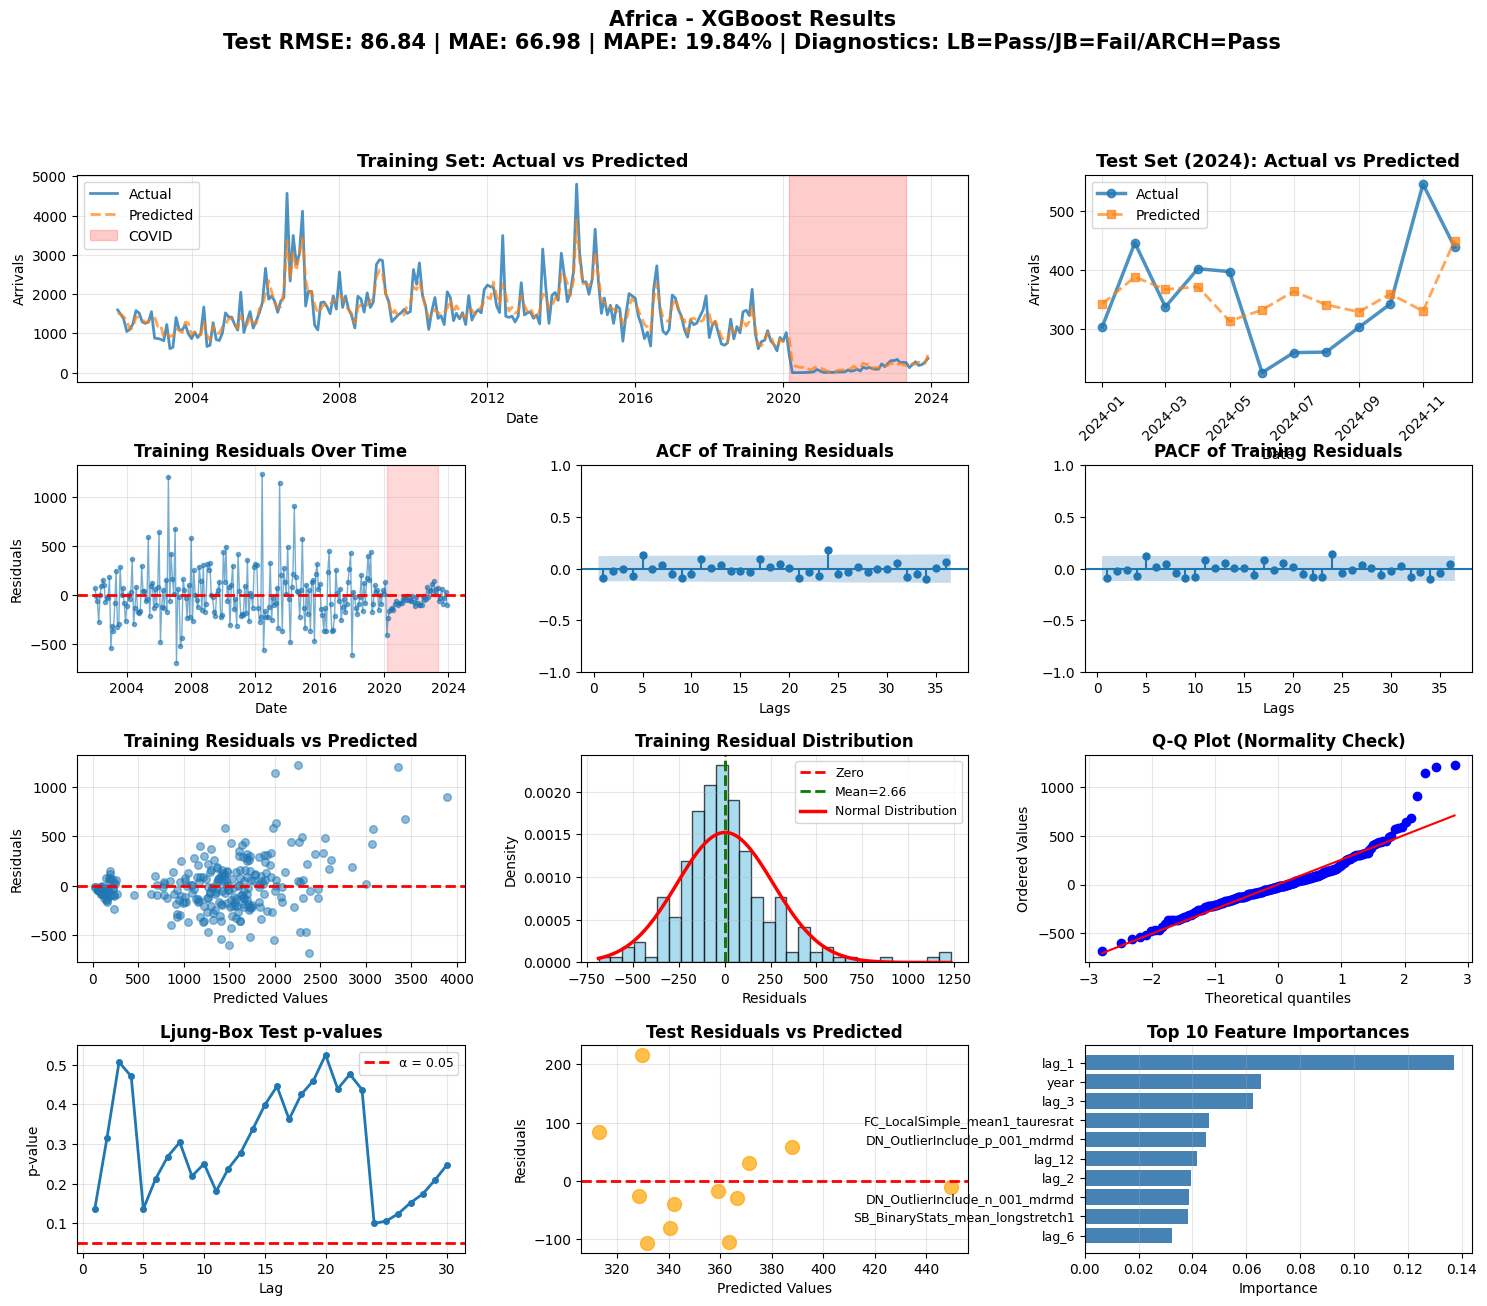


Gerando gráficos para: America_Central_E_Caribe

--- Residual Diagnostics (Training Set) ---
Residual Mean: -1.1983
Residual Std: 66.18

T-Test for Zero Mean:
  t-statistic: -0.2936
  p-value: 0.7693
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (3.31)

Ljung-Box Test (lag 24):
  p-value: 0.0614
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 35.1040
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.4222
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


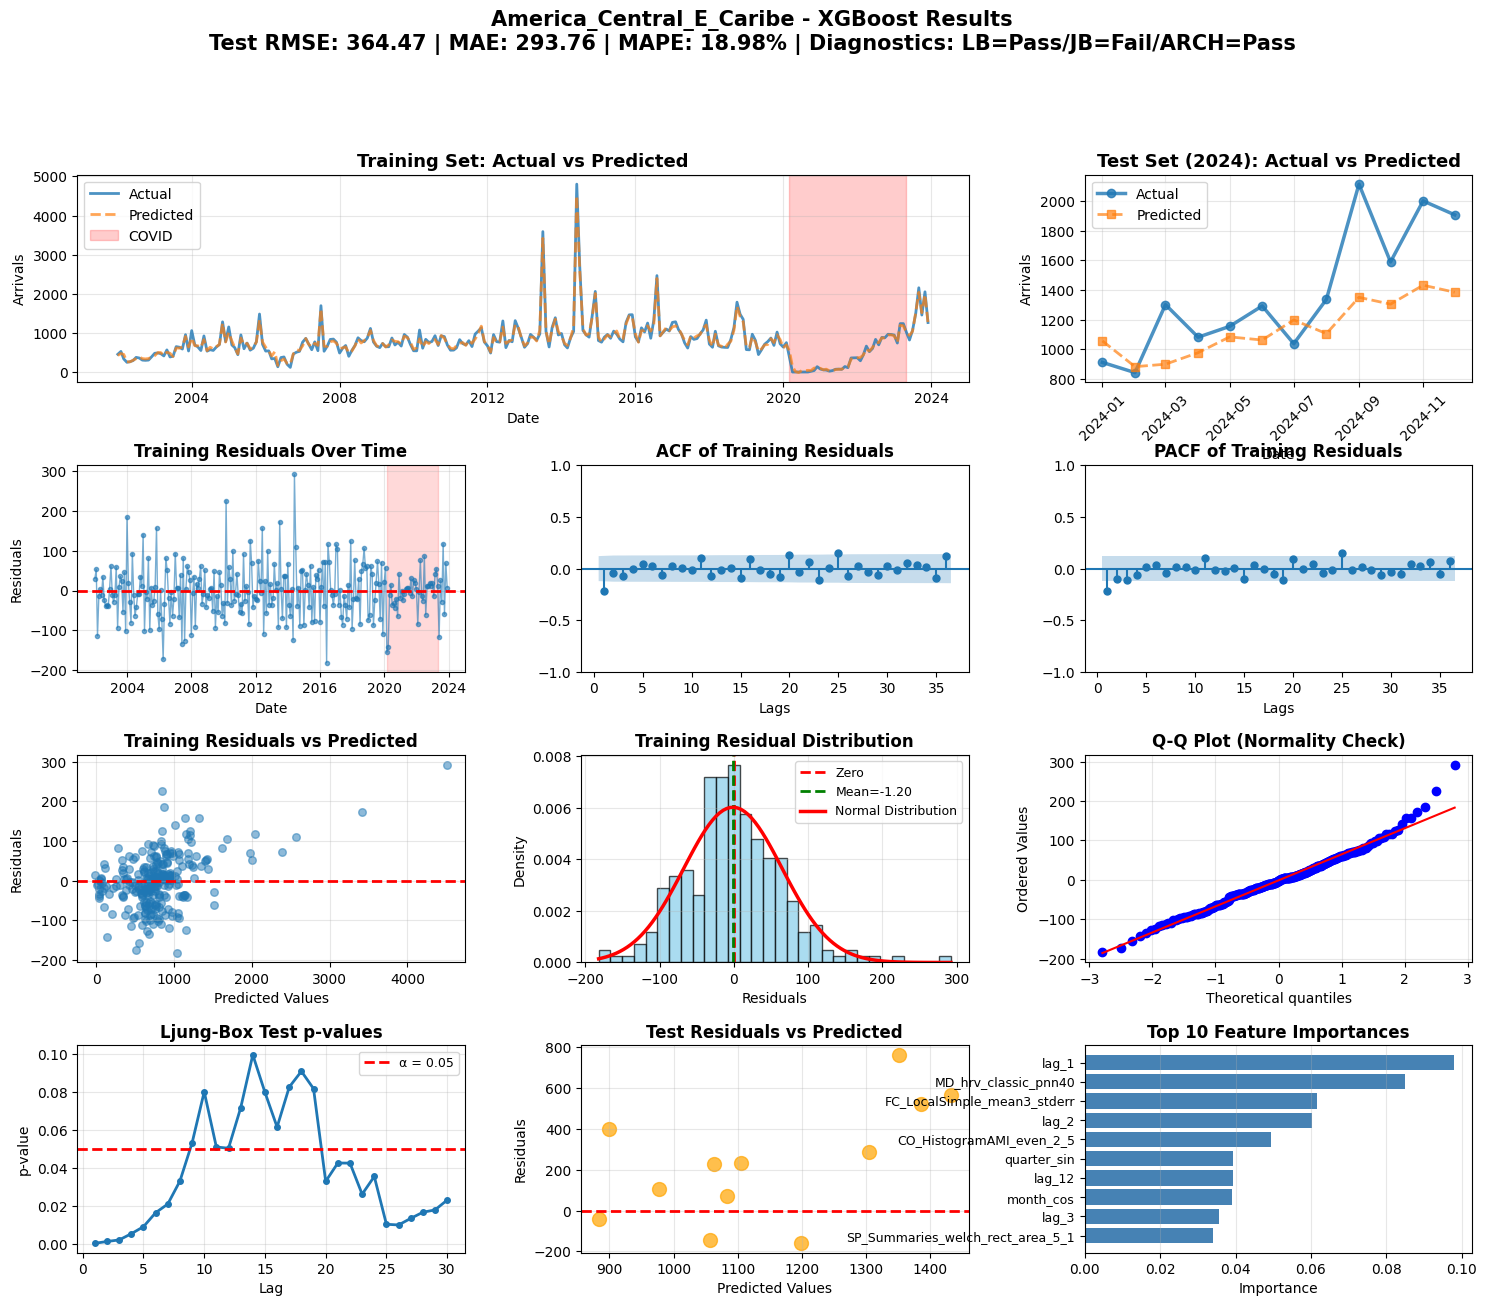


Gerando gráficos para: America_Do_Norte

--- Residual Diagnostics (Training Set) ---
Residual Mean: 11.6305
Residual Std: 1086.79

T-Test for Zero Mean:
  t-statistic: 0.1736
  p-value: 0.8624
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (54.34)

Ljung-Box Test (lag 24):
  p-value: 0.8486
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 3974.4894
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.9877
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


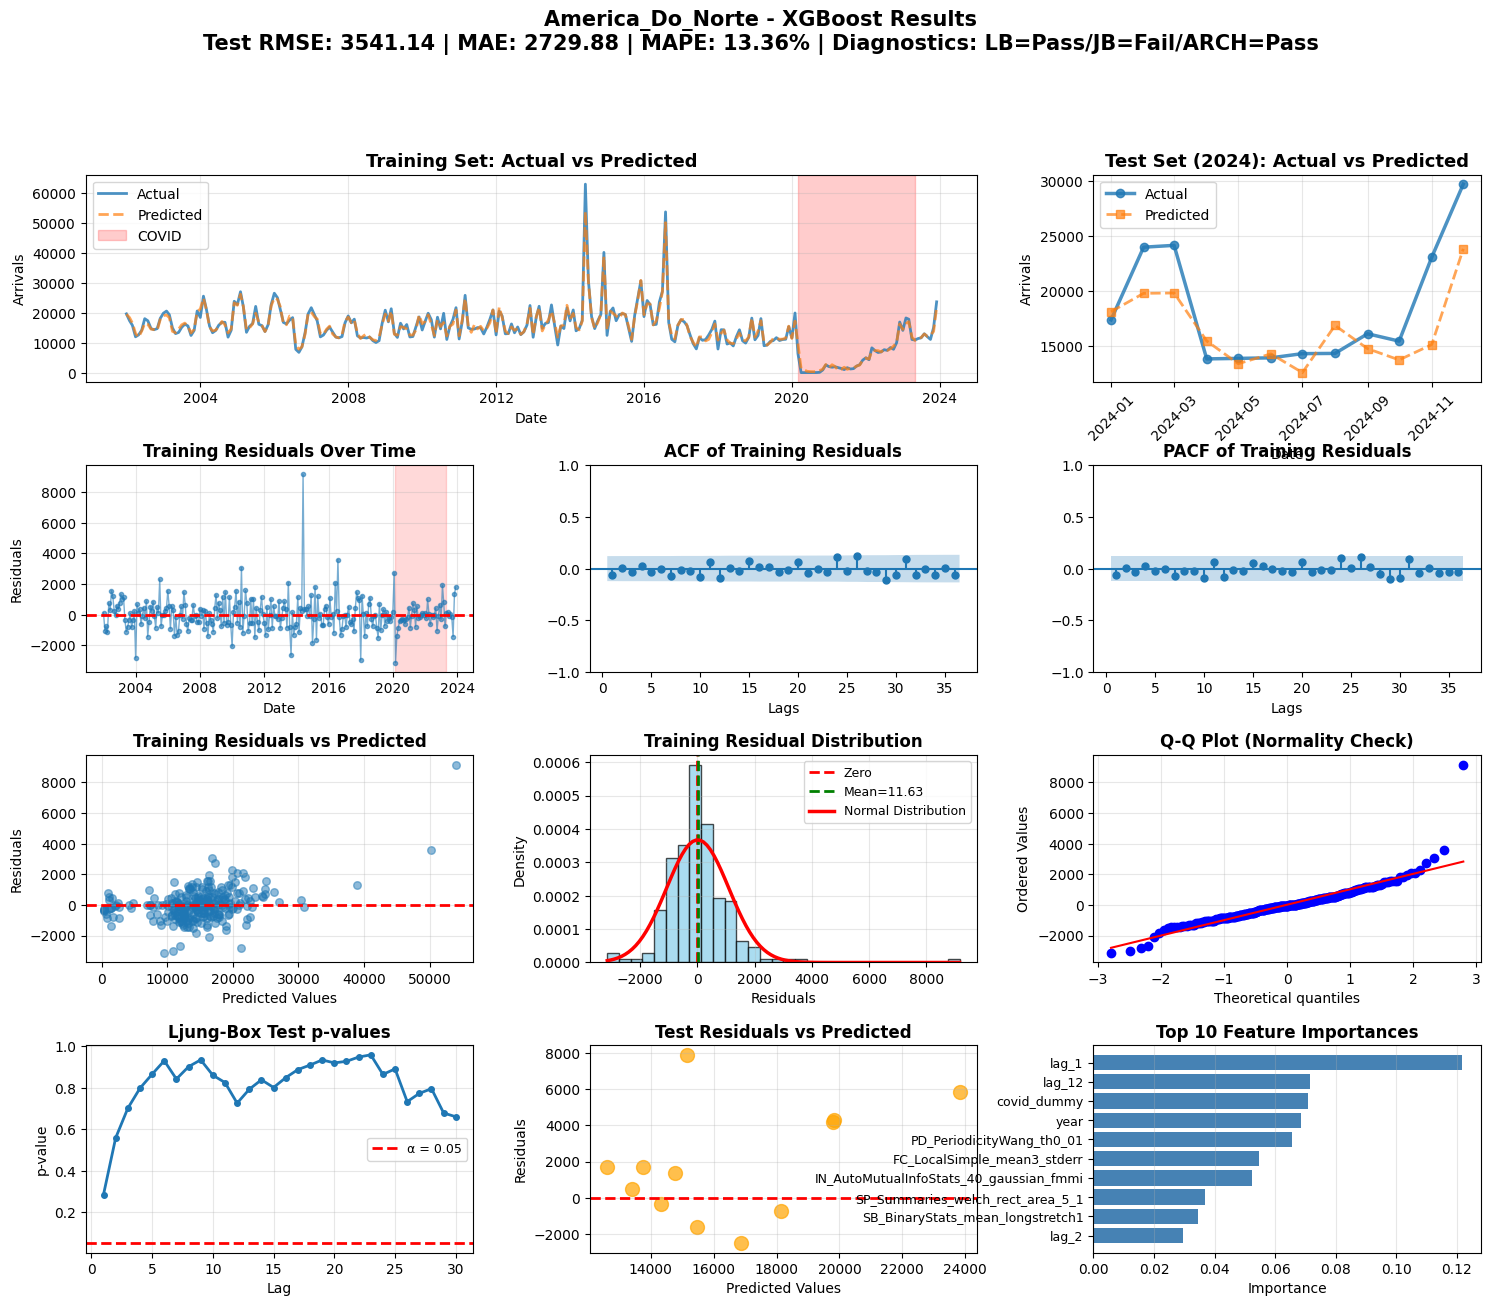


Gerando gráficos para: America_Do_Sul

--- Residual Diagnostics (Training Set) ---
Residual Mean: 42.8652
Residual Std: 2684.42

T-Test for Zero Mean:
  t-statistic: 0.2590
  p-value: 0.7959
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (134.22)

Ljung-Box Test (lag 24):
  p-value: 0.2731
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 450.5490
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.1450
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


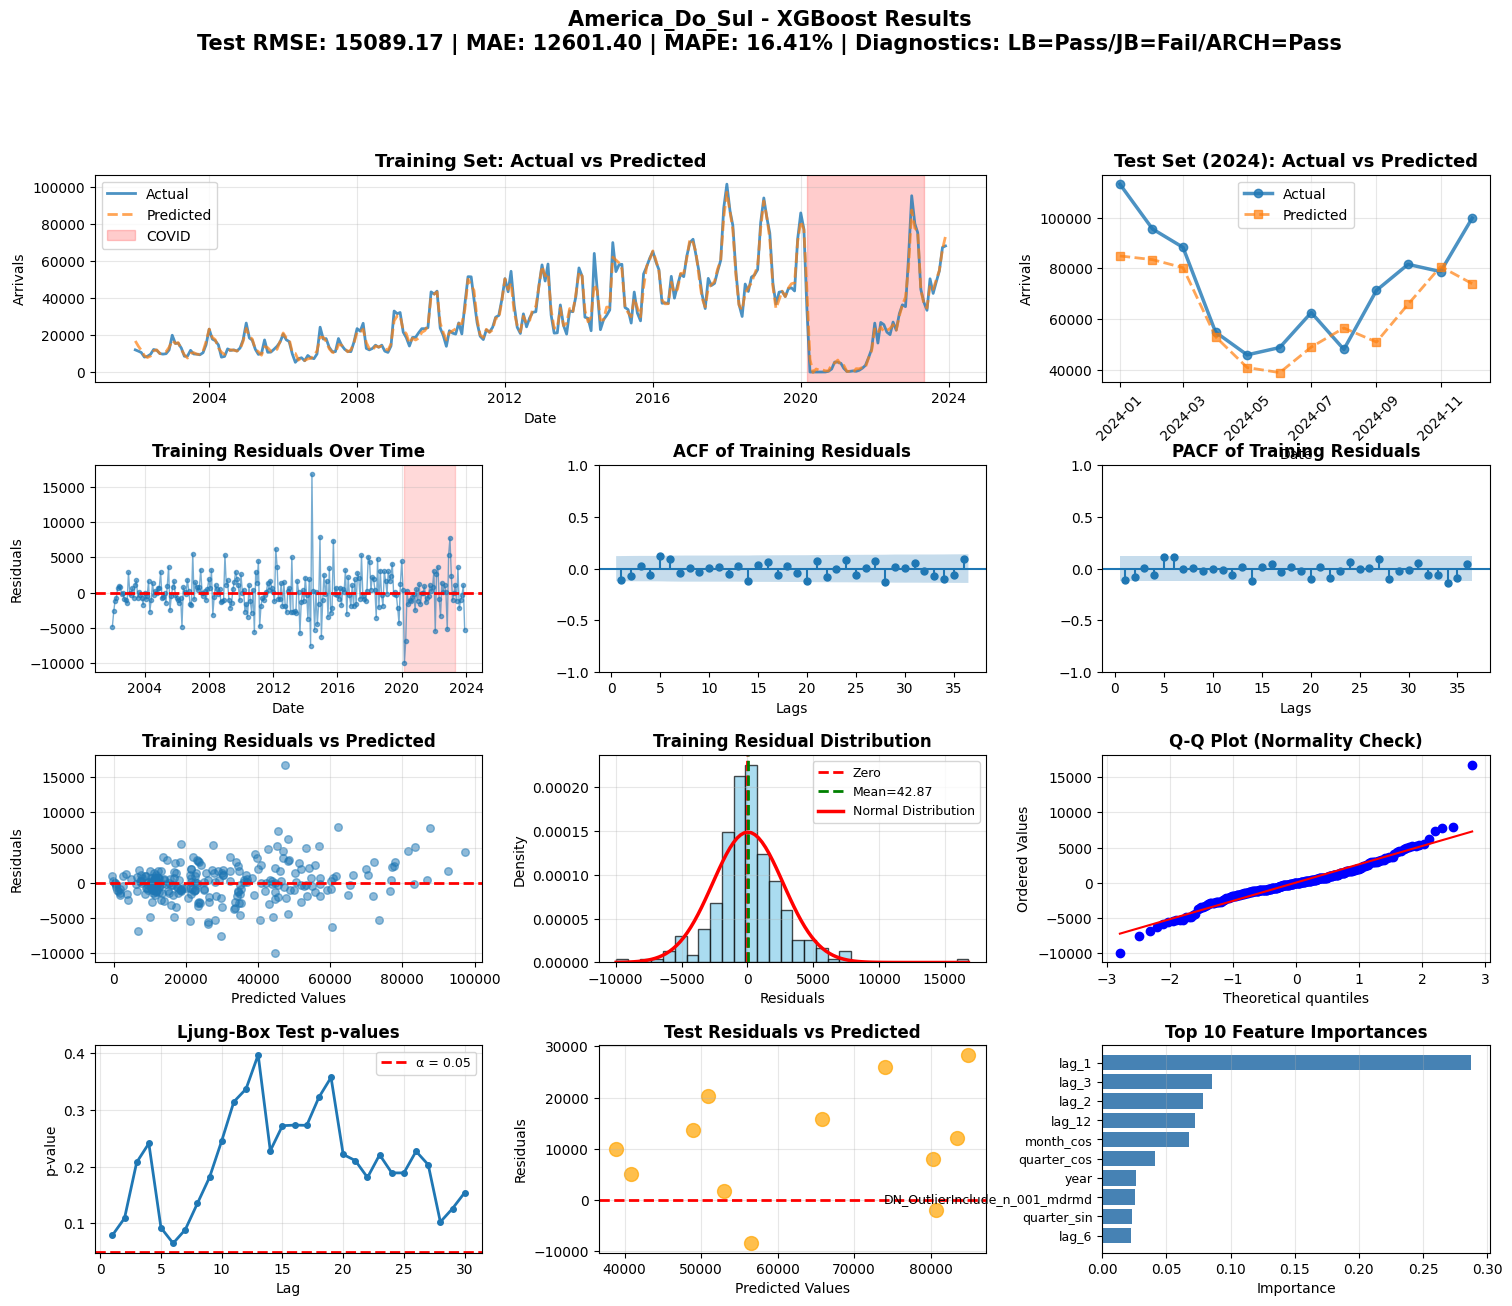


Gerando gráficos para: Asia

--- Residual Diagnostics (Training Set) ---
Residual Mean: 10.2526
Residual Std: 1381.14

T-Test for Zero Mean:
  t-statistic: 0.1204
  p-value: 0.9043
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (69.06)

Ljung-Box Test (lag 24):
  p-value: 0.0000
  ✗ FAIL: Significant autocorrelation detected (p < 0.05)

Jarque-Bera Test (Normality):
  Statistic: 12384.8435
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.4117
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


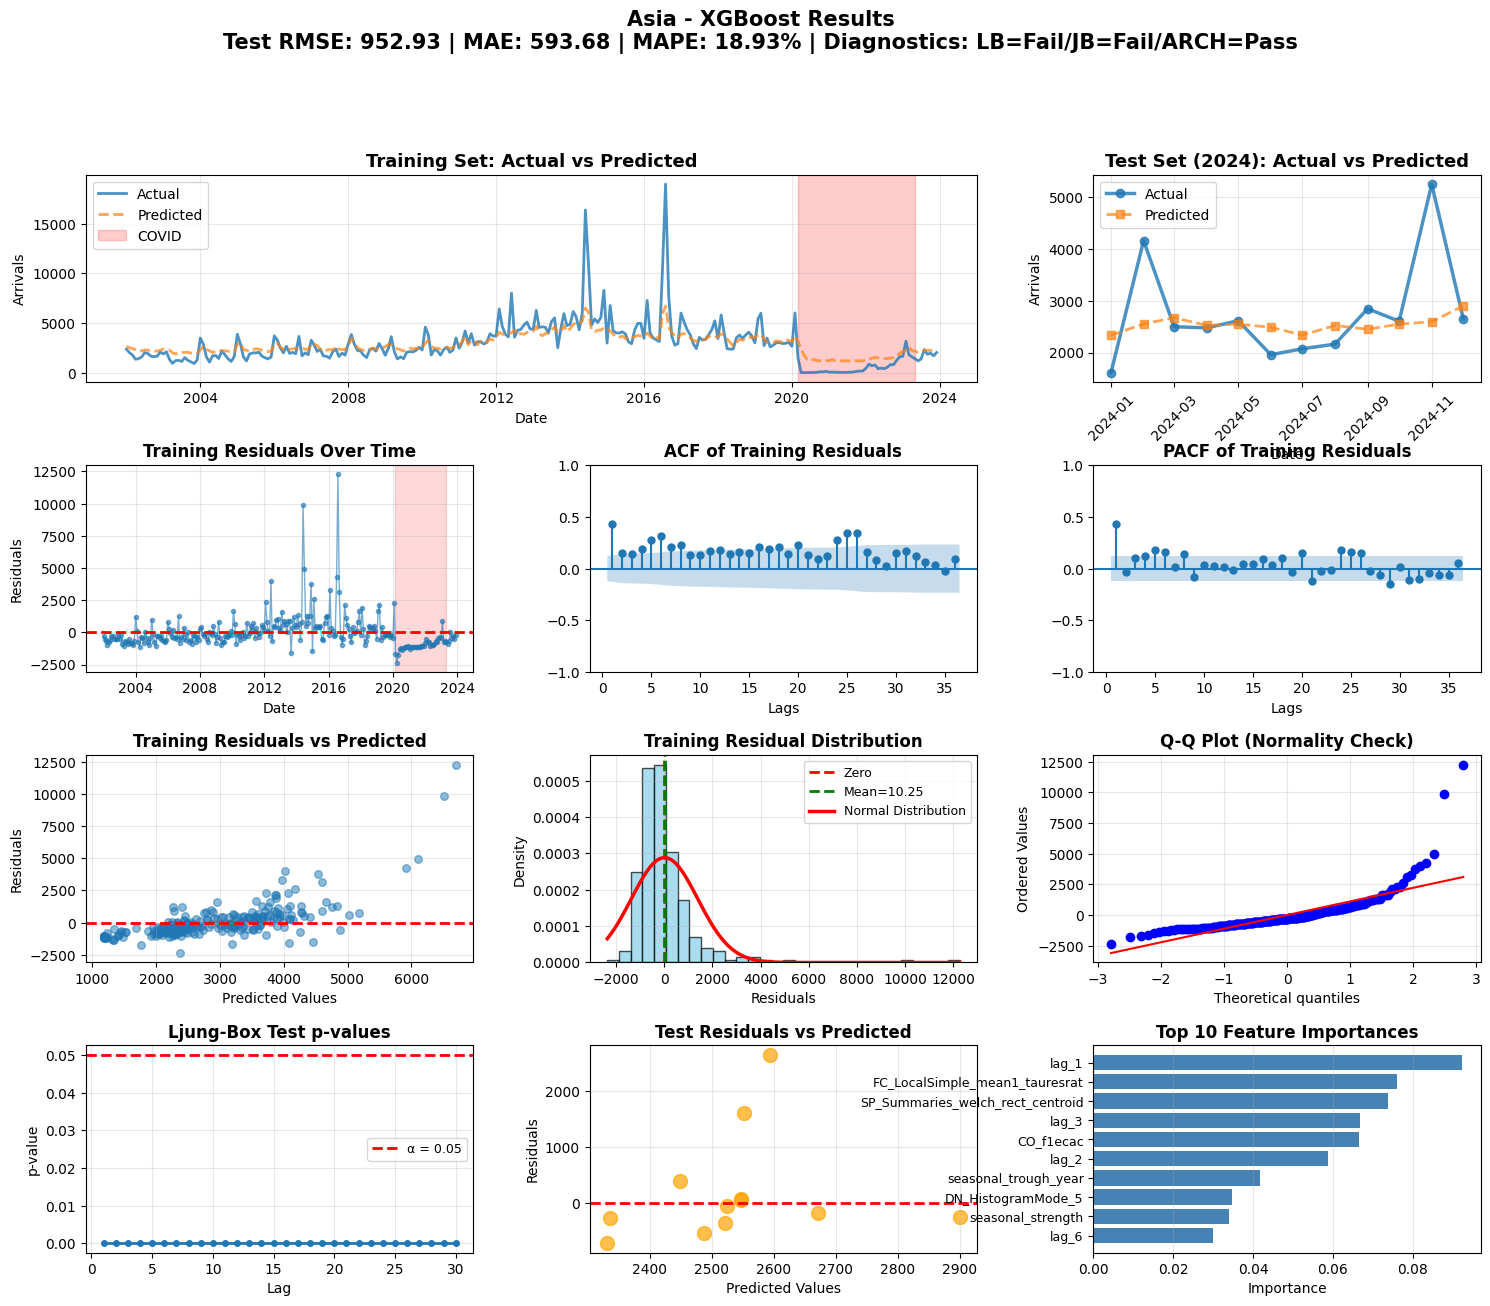


Gerando gráficos para: Europa

--- Residual Diagnostics (Training Set) ---
Residual Mean: 21.4595
Residual Std: 1262.99

T-Test for Zero Mean:
  t-statistic: 0.2755
  p-value: 0.7831
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (63.15)

Ljung-Box Test (lag 24):
  p-value: 0.1870
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 241.8593
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.6277
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


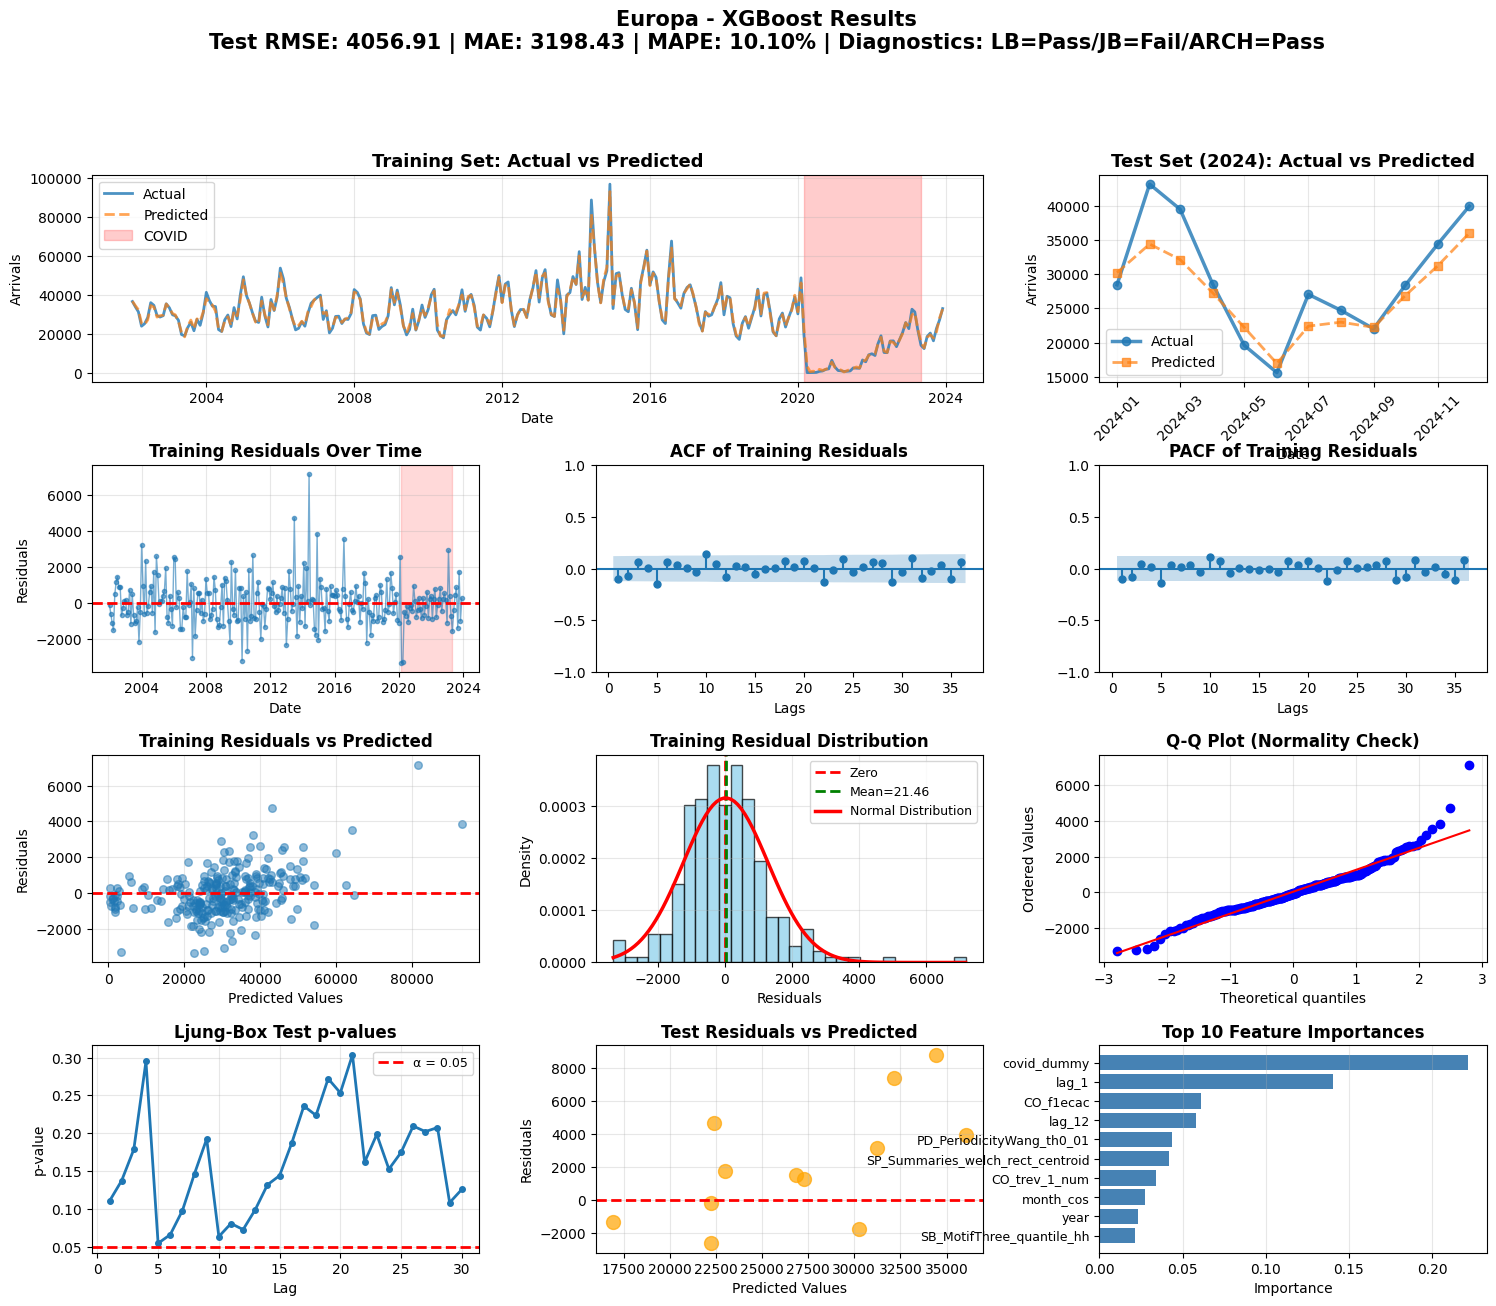


Gerando gráficos para: Oceania

--- Residual Diagnostics (Training Set) ---
Residual Mean: 2.7157
Residual Std: 235.29

T-Test for Zero Mean:
  t-statistic: 0.1872
  p-value: 0.8517
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (11.76)

Ljung-Box Test (lag 24):
  p-value: 0.1576
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 10571.4209
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.9958
  ✓ PASS: No heteroskedasticity (p > 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


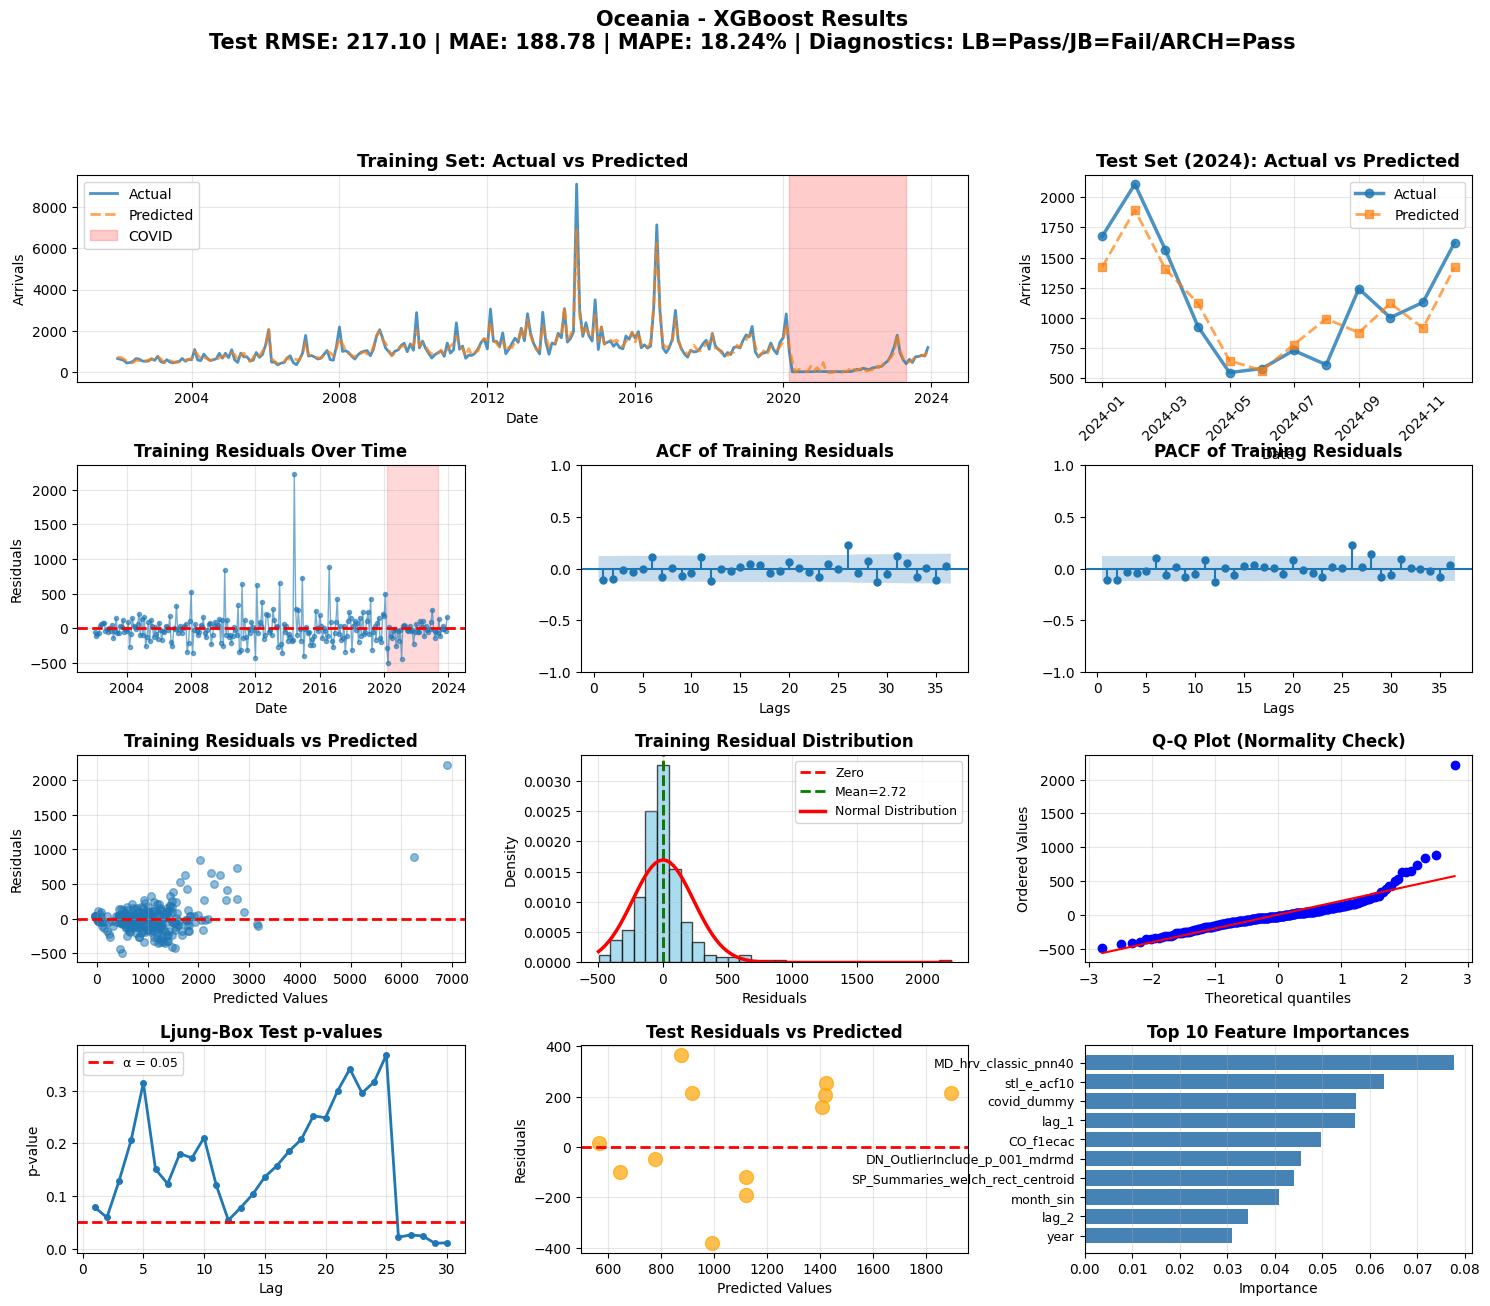


Gerando gráficos para: Total

--- Residual Diagnostics (Training Set) ---
Residual Mean: 143.5916
Residual Std: 5277.71

T-Test for Zero Mean:
  t-statistic: 0.4412
  p-value: 0.6594
  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)
  ✓✓ EXCELENTE: |Mean| < 5% do Std (263.89)

Ljung-Box Test (lag 24):
  p-value: 0.1285
  ✓ PASS: No significant autocorrelation (p > 0.05)

Jarque-Bera Test (Normality):
  Statistic: 148.8605
  p-value: 0.0000
  ✗ FAIL: Residuals are not normally distributed (p < 0.05)

ARCH Test (Heteroskedasticity):
  p-value: 0.0178
  ✗ FAIL: Heteroskedasticity detected (p < 0.05)

--- Overall Residual Diagnostics ---
⚠️ SOME TESTS FAILED - Review residual diagnostics


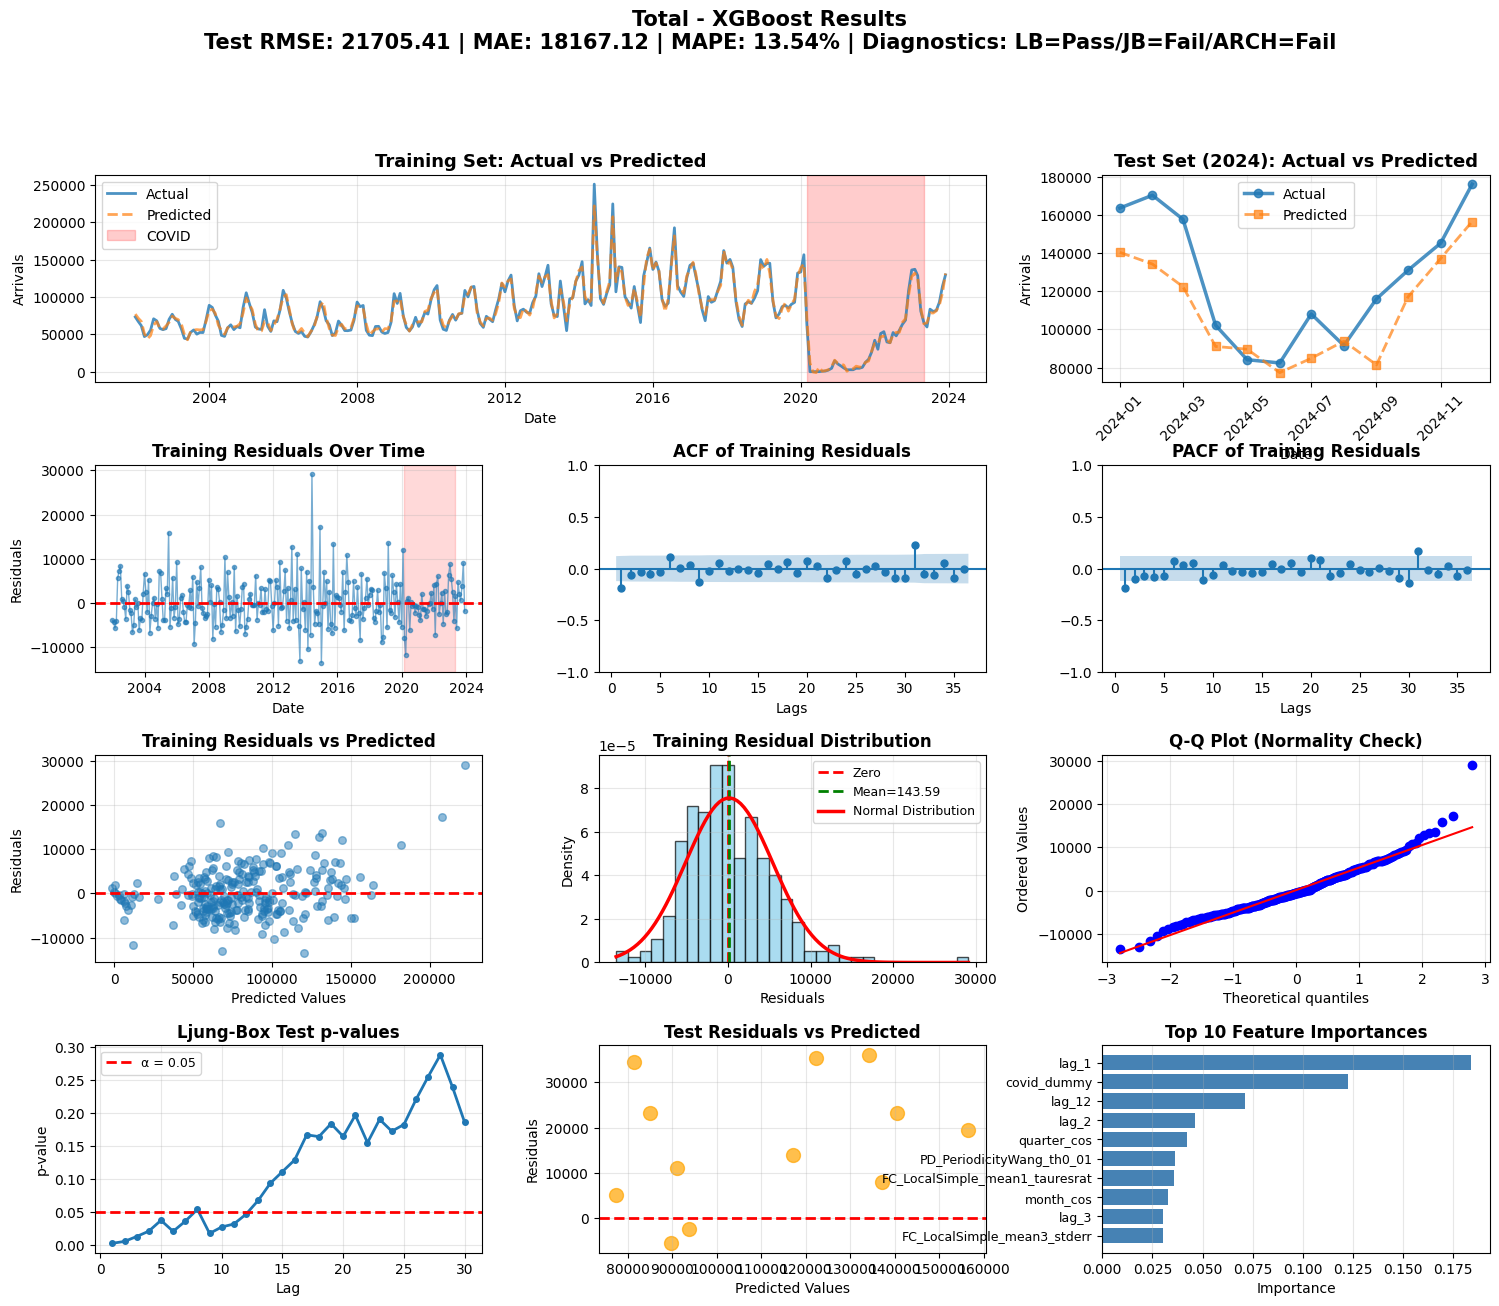


✓ Todas as visualizações criadas


In [14]:
print("="*80)
print("VISUALIZAÇÕES - XGBOOST RESULTADOS")
print("="*80 + "\n")

# Import necessário para ACF/PACF e testes estatísticos
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# Para cada continente, criar gráficos
for continent in continents:
    if continent not in xgb_models:
        continue
    
    print(f"\nGerando gráficos para: {continent.title()}")
    
    model_data = xgb_models[continent]
    train_data = model_data['train_data']
    test_data = model_data['test_data']
    y_pred_train = model_data['y_pred_train']
    y_pred_test = model_data['y_pred_test']
    feature_importance = model_data['feature_importance']
    
    # Calculate residuals
    residuals_train = train_data['arrivals'].values - y_pred_train
    residuals_test = test_data['arrivals'].values - y_pred_test
    
    # ========================================
    # RESIDUAL DIAGNOSTICS
    # ========================================
    print(f"\n--- Residual Diagnostics (Training Set) ---")
    print(f"Residual Mean: {residuals_train.mean():.4f}")
    print(f"Residual Std: {residuals_train.std():.2f}")

        # 0. T-Test for Zero Mean (NEW!)
    print(f"\nT-Test for Zero Mean:")
    from scipy.stats import ttest_1samp
    t_stat, t_pvalue = ttest_1samp(residuals_train, 0)
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {t_pvalue:.4f}")
    
    # Calcular threshold baseado em % do desvio padrão
    threshold_5pct = 0.05 * residuals_train.std()
    threshold_10pct = 0.10 * residuals_train.std()
    mean_abs = abs(residuals_train.mean())
    
    if t_pvalue > 0.05:
        print(f"  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)")
        if mean_abs < threshold_5pct:
            print(f"  ✓✓ EXCELENTE: |Mean| < 5% do Std ({threshold_5pct:.2f})")
            mean_result = "Excellent"
        elif mean_abs < threshold_10pct:
            print(f"  ✓ BOM: |Mean| < 10% do Std ({threshold_10pct:.2f})")
            mean_result = "Good"
        else:
            print(f"  ⚠️ ACEITÁVEL: |Mean| > 10% do Std, mas estatisticamente = 0")
            mean_result = "Acceptable"
    else:
        print(f"  ✗ FAIL: Mean é significativamente diferente de zero (p < 0.05)")
        if residuals_train.mean() > 0:
            print(f"  → Modelo SUBESTIMA sistematicamente os valores reais")
        else:
            print(f"  → Modelo SUPERESTIMA sistematicamente os valores reais")
        mean_result = "Biased"
    
    # 1. Ljung-Box Test (autocorrelation) - 24 lags
    print(f"\nLjung-Box Test (lag 24):")
    lb_test = acorr_ljungbox(residuals_train, lags=16, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[-1]  # Last lag p-value
    print(f"  p-value: {lb_pvalue:.4f}")
    if lb_pvalue > 0.05:
        print(f"  ✓ PASS: No significant autocorrelation (p > 0.05)")
        lb_result = "Pass"
    else:
        print(f"  ✗ FAIL: Significant autocorrelation detected (p < 0.05)")
        lb_result = "Fail"
    
    # 2. Jarque-Bera Test (normality)
    jb_stat, jb_pvalue = stats.jarque_bera(residuals_train)
    print(f"\nJarque-Bera Test (Normality):")
    print(f"  Statistic: {jb_stat:.4f}")
    print(f"  p-value: {jb_pvalue:.4f}")
    if jb_pvalue > 0.05:
        print(f"  ✓ PASS: Residuals are normally distributed (p > 0.05)")
        jb_result = "Pass"
    else:
        print(f"  ✗ FAIL: Residuals are not normally distributed (p < 0.05)")
        jb_result = "Fail"
    
    # 3. Heteroskedasticity (ARCH test)
    from statsmodels.stats.diagnostic import het_arch
    try:
        arch_test = het_arch(residuals_train, nlags=10)
        arch_pvalue = arch_test[1]
        print(f"\nARCH Test (Heteroskedasticity):")
        print(f"  p-value: {arch_pvalue:.4f}")
        if arch_pvalue > 0.05:
            print(f"  ✓ PASS: No heteroskedasticity (p > 0.05)")
            arch_result = "Pass"
        else:
            print(f"  ✗ FAIL: Heteroskedasticity detected (p < 0.05)")
            arch_result = "Fail"
    except:
        arch_result = "Error"
        arch_pvalue = np.nan
        print(f"\nARCH Test: Could not be performed")
    
    # Overall diagnostic result
    print(f"\n--- Overall Residual Diagnostics ---")
    all_pass = all([lb_result == "Pass", jb_result == "Pass", arch_result == "Pass"])
    if all_pass:
        print("✓✓✓ ALL TESTS PASSED - Model residuals are well-behaved")
        diagnostic_result = "All Pass"
    else:
        print("⚠️ SOME TESTS FAILED - Review residual diagnostics")
        diagnostic_result = "Some Fail"
    
    # ========================================
    # VISUALIZATION
    # ========================================
    
    # Create figure with subplots (aumentado para 4x3)
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)
    
    # Plot 1: Train - Actual vs Predicted
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(train_data['date'], train_data['arrivals'], label='Actual', linewidth=2, alpha=0.8)
    ax1.plot(train_data['date'], y_pred_train, label='Predicted', linewidth=2, alpha=0.7, linestyle='--')
    ax1.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2023-05-01'), 
                alpha=0.2, color='red', label='COVID')
    ax1.set_title('Training Set: Actual vs Predicted', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Arrivals')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Test - Actual vs Predicted
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(test_data['date'], test_data['arrivals'], label='Actual', 
             linewidth=2.5, marker='o', markersize=6, alpha=0.8)
    ax2.plot(test_data['date'], y_pred_test, label='Predicted', 
             linewidth=2, alpha=0.7, marker='s', markersize=6, linestyle='--')
    ax2.set_title('Test Set (2024): Actual vs Predicted', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Arrivals')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Residuals Over Time (Train)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(train_data['date'], residuals_train, marker='o', markersize=3, alpha=0.6, linewidth=1)
    ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax3.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2023-05-01'), 
                alpha=0.15, color='red')
    ax3.set_title('Training Residuals Over Time', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=10)
    ax3.set_ylabel('Residuals', fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: ACF of Residuals (Training)
    ax4 = fig.add_subplot(gs[1, 1])
    plot_acf(residuals_train, lags=36, ax=ax4, zero=False)
    ax4.set_title('ACF of Training Residuals', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Lags', fontsize=10)
    
    # Plot 5: PACF of Residuals (Training)
    ax5 = fig.add_subplot(gs[1, 2])
    plot_pacf(residuals_train, lags=36, ax=ax5, zero=False, method='ywm')
    ax5.set_title('PACF of Training Residuals', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Lags', fontsize=10)
    
    # Plot 6: Residuals vs Fitted (Train)
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.scatter(y_pred_train, residuals_train, alpha=0.5, s=30)
    ax6.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax6.set_title('Training Residuals vs Predicted', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Predicted Values', fontsize=10)
    ax6.set_ylabel('Residuals', fontsize=10)
    ax6.grid(True, alpha=0.3)
    
    # Plot 7: Histogram of Residuals with Normal Overlay
    ax7 = fig.add_subplot(gs[2, 1])
    ax7.hist(residuals_train, bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
    ax7.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero')
    ax7.axvline(x=residuals_train.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean={residuals_train.mean():.2f}')
    
    # Add normal distribution overlay
    mu, sigma = residuals_train.mean(), residuals_train.std()
    x = np.linspace(residuals_train.min(), residuals_train.max(), 100)
    ax7.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2.5, label='Normal Distribution')
    
    ax7.set_title('Training Residual Distribution', fontsize=12, fontweight='bold')
    ax7.set_xlabel('Residuals', fontsize=10)
    ax7.set_ylabel('Density', fontsize=10)
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3)
    
    # Plot 8: Q-Q Plot (Normal probability plot)
    ax8 = fig.add_subplot(gs[2, 2])
    stats.probplot(residuals_train, dist="norm", plot=ax8)
    ax8.set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
    ax8.grid(True, alpha=0.3)
    
    # Plot 9: Ljung-Box p-values by Lag
    ax9 = fig.add_subplot(gs[3, 0])
    lb_test_full = acorr_ljungbox(residuals_train, lags=30, return_df=True)
    ax9.plot(lb_test_full.index, lb_test_full['lb_pvalue'], marker='o', linewidth=2, markersize=4)
    ax9.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='α = 0.05')
    ax9.set_title('Ljung-Box Test p-values', fontsize=12, fontweight='bold')
    ax9.set_xlabel('Lag', fontsize=10)
    ax9.set_ylabel('p-value', fontsize=10)
    ax9.legend(fontsize=9)
    ax9.grid(True, alpha=0.3)
    
    # Plot 10: Test Residuals vs Predicted
    ax10 = fig.add_subplot(gs[3, 1])
    ax10.scatter(y_pred_test, residuals_test, alpha=0.7, s=100, color='orange')
    ax10.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax10.set_title('Test Residuals vs Predicted', fontsize=12, fontweight='bold')
    ax10.set_xlabel('Predicted Values', fontsize=10)
    ax10.set_ylabel('Residuals', fontsize=10)
    ax10.grid(True, alpha=0.3)
    
    # Plot 11: Feature Importance
    ax11 = fig.add_subplot(gs[3, 2])
    top_features = feature_importance.head(10)
    ax11.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    ax11.set_yticks(range(len(top_features)))
    ax11.set_yticklabels(top_features['feature'], fontsize=9)
    ax11.invert_yaxis()
    ax11.set_title('Top 10 Feature Importances', fontsize=12, fontweight='bold')
    ax11.set_xlabel('Importance', fontsize=10)
    ax11.grid(True, alpha=0.3, axis='x')
    
    # Overall title
    continent_display = "TOTAL (Agregado)" if continent == 'TOTAL' else continent.title()
    
    # ✅ FIX: Buscar pelo nome ORIGINAL (lowercase) em results_df
    result = results_df[results_df['Continent'] == continent].iloc[0]
    
    plt.suptitle(f"{continent.title()} - XGBoost Results\n" + 
                 f"Test RMSE: {result['Test_RMSE']:.2f} | MAE: {result['Test_MAE']:.2f} | MAPE: {result['Test_MAPE']:.2f}% | " +
                 f"Diagnostics: LB={lb_result}/JB={jb_result}/ARCH={arch_result}",
                 fontsize=15, fontweight='bold', y=0.998)
    
    plt.show()

print("\n✓ Todas as visualizações criadas")